In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb -qU

In [ ]:
!pip install --upgrade wandb

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fangyua (fangyua-univeristy-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from tqdm import tqdm
import random

In [4]:
# hyperparameter
# a sequence is like "11+1=12"
batch_size = 128 # there are batch_size sequences in one batch, each sequence contains block_size tokens, each token is mapped to a n_embd vector
block_size = 36 # maximum sequence length, padding ensures that every sequence in a batch must has length of block_size, for 11-digits addition
n_embd = 128 # each token is mapped to a 256-dimensional vector
n_head = 4
n_layer = 4
max_iters = 84800
dropout = 0.1
num_samples = 1000
max_new_tokens = 10 # for 6 digits addition
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 20
bias = True

In [5]:
wandb.init(
    project="transformer_arithmetic_wandb",
    config={
        "max_iters": 84800,
        "num_samples": 1000,
        "phase_2": [0.5, 0.5],
        "phase_3": [0.25, 0.35, 0.40],
        "phase_4": [0.1, 0.3, 0.3, 0.30],
        "phase_5": [0.15, 0.2, 0.2, 0.2, 0.25],
        "phase_6": [0.05, 0.075, 0.1, 0.15, 0.25, 0.375],
        "phase_1 iter": 1000,
        "phase_2 iter": 3000,
        "phase_3 iter": 6000,
        "phase_4 iter": 15000,
        "phase_5 iter": 20000,
        "phase_6 iter": 23000,
        "mixed_digits iter": 16000,
        "phase_train_distribution":[0.05,0.1,0.2,0.2,0.25,0.2],
        "n_embd": 128,
        "n_head": 32,
        "n_layer": 8

    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [6]:
# Define characters and mappings
# <pad>: 0, <eos>: 13
chars = ["<pad>", "+", "=", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "<eos>"]  # Add padding token
stoi = {ch: i for i, ch in enumerate(chars)}  # Character-to-index mapping
itos = {i: ch for ch, i in stoi.items()}  # Index-to-character mapping
padding_idx = stoi["<pad>"]  # Index for the padding token
eos_idx = stoi["<eos>"]
vocab_size = len(chars)

In [7]:
# Encode and decode functions
def encode(seq):
    return [stoi[ch] for ch in seq]

def decode(indices):
    return ''.join([itos[idx] for idx in indices])


In [8]:
# 6-digits online sampling
digit_ranges = {
    1: (0, 9),
    2: (10, 99),
    3: (100, 999),
    4: (1000, 9999),
    5: (10000, 99999),
    6: (100000, 999999),
    7: (1000000, 9999999)
}

digit_distribution = {
    1: [1],
    2: [0.5, 0.5],
    3: [0.25, 0.35, 0.4],
    4: [0.1, 0.3, 0.3, 0.3],
    5: [0.15, 0.2, 0.2, 0.2, 0.25],
    6: [0.05, 0.075, 0.1, 0.15, 0.25, 0.375],
    7: [0.025, 0.05, 0.1, 0.15, 0.15, 0.25, 0.275]
}

# generate certain digits number: sample_number(3) outputs 3-digits number: 754
def sample_number(digit_distribution):
  lower_bound, higher_bound = digit_ranges[digit_distribution]
  return np.random.randint(lower_bound, higher_bound+1)

def generate_equation(phase):

    if phase == 1:
        left_digit = 1
        right_digit = 1
    else:
        distribution = digit_distribution[phase]
        choices = list(range(1, phase + 1))
        left_digit = np.random.choice(choices, p=distribution)
        right_digit = phase

    # Sample the actual numbers:
    a = sample_number(left_digit)
    b = sample_number(right_digit)

    result_normal = a + b
    result = str(result_normal)[::-1]
    reverse_a = str(a)[::-1]
    reverse_b = str(b)[::-1]

    # Create the equation string
    equation_str = f"{reverse_a}+{reverse_b}={result}"

    # Convert the equation string into token IDs.
    equation_ids = [stoi[ch] for ch in equation_str]
    equation_ids.append(stoi["<eos>"])

    return equation_ids


In [10]:
# test for generate_equation()
for _ in range(5):
  print(decode(generate_equation(3)))

806+766=5721<eos>
486+685=0721<eos>
837+485=2231<eos>
71+018=728<eos>
418+241=659<eos>


In [11]:
def pad_sequence(sequence, block_size, padding_idx):
    if len(sequence) < block_size:
        sequence += [padding_idx] * (block_size - len(sequence))  # Add <pad> tokens
    return sequence

def get_batch(batch_size, phase, block_size):
    batch_ids = [generate_equation(phase) for _ in range(batch_size)]

    batch_encoded = [
        pad_sequence(seq, block_size, padding_idx)
        for seq in batch_ids
    ]

    x = torch.tensor([seq[:-1] for seq in batch_encoded], dtype=torch.long)
    y = torch.tensor([seq[1:] for seq in batch_encoded], dtype=torch.long)
    return x.to(device), y.to(device)

In [12]:
@torch.no_grad()
def estimate_loss(phase):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(batch_size, phase, block_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias=True): # class constructor
        super().__init__()
        # nn.Parameter, pytorch optimize will update the value of this parameter during training
        self.weight = nn.Parameter(torch.ones(ndim)) # trainable parameter
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None # trainable parameter

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, bias=True):
        super().__init__()
        assert n_embd % n_head == 0, "Embedding dimension must be divisible by the number of heads."

        # Store hyperparameters
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        self.block_size = block_size

        # Key, Query, Value projections
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=bias)
        # Output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=bias)
        # Regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        # Check for Flash Attention availability
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # Causal mask for slow attention
            self.register_buffer(
                "bias",
                torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)
            )

    def forward(self, x):
        B, T, C = x.size()  # Batch size, sequence length, embedding dimension

        # Compute Q, K, V
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)  # Split into Q, K, V (B, T, n_embd)

        # Reshape for multi-head attention
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, n_head, T, head_size)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, n_head, T, head_size)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, n_head, T, head_size)

        # Flash Attention or fallback to manual implementation
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v,
                attn_mask=None,
                dropout_p=self.dropout if self.training else 0,
                is_causal=True
            )
        else:
            # Manual attention with causal masking
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))  # Scaled dot product
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))  # Apply causal mask
            att = F.softmax(att, dim=-1)  # Normalize attention scores
            att = self.attn_dropout(att)
            y = att @ v  # Apply attention weights to values (B, n_head, T, head_size)

        # Reshape back to original format
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # Reassemble heads

        # Output projection and residual dropout
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module): # FFN

    def __init__(self, n_embd, dropout, bias=True):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=bias)
        self.gelu    = nn.GELU() # nonlinear activation function
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, bias=True):
        super().__init__()
        # LayerNorm and CausalSelfAttention with explicit parameters
        self.ln_1 = LayerNorm(n_embd, bias=bias)
        self.attn = CausalSelfAttention(n_embd, n_head, dropout, block_size, bias=bias)
        self.ln_2 = LayerNorm(n_embd, bias=bias)
        self.mlp = MLP(n_embd, dropout, bias=bias)  # MLP with explicit parameters

    def forward(self, x):
        # Apply residual connection and pre-normalization
        x = x + self.attn(self.ln_1(x))  # Apply LayerNorm before attention
        x = x + self.mlp(self.ln_2(x))  # Apply LayerNorm before MLP
        return x

In [14]:
class GPT(nn.Module):

    def __init__(self, vocab_size, block_size, n_embd, n_layer, n_head, dropout, bias=True):
        super().__init__()
        assert vocab_size is not None
        assert block_size is not None
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.dropout = dropout
        self.bias = bias

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd), # token embeddings
            wpe = nn.Embedding(block_size, n_embd), # positional embeddings FIX argument: pe_type = ape
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(n_embd, n_head, dropout, block_size, bias=bias) for _ in range(n_layer)]), # a stack of n_layer blocks
            ln_f = LayerNorm(n_embd, bias=bias), # final layer norm
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False) # projects the final transformer output to the vocab size

        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.cblock_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=padding_idx)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=0.2, top_k=1):
        for _ in range(max_new_tokens):
            # prepare the input
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]

            # forward pass through the model
            logits, _ = self(idx_cond)
            # scale the logits for the last token only
            logits = logits[:, -1, :] / temperature

            # keep only the top_k tokens and set others to -inf
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # convert logits into probs
            probs = F.softmax(logits, dim=-1)
            # sample the next token from multinomial distribtuion
            idx_next = torch.multinomial(probs, num_samples=1)

            # break generate if reach <eos> for all sequence
            if (idx_next == eos_idx).all():
              break

            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [15]:
phase_1_iter = 1000
phase_2_iter = 3000
phase_3_iter = 6000
phase_4_iter = 15000
phase_5_iter = 20000
phase_6_iter = 23000
phase_2_3_transition = 200
phase_3_4_transition = 200
phase_4_5_transition = 200
phase_5_6_transition = 200


phase_1_end = phase_1_iter
phase_2_end = phase_1_end + phase_2_iter
phase_3_end = phase_2_end + phase_3_iter
phase_4_end = phase_3_end + phase_4_iter
phase_5_end = phase_4_end + phase_5_iter
phase_6_end = phase_5_end + phase_6_iter

mixed_digit_distribution = [0.01,0.04,0.1,0.15,0.3,0.4]

def get_phase(iter_num, max_iters):
    # phase 1 training
    if iter_num < phase_1_end:
        return 1

    # phase 2 training
    if iter_num < phase_2_end:
      return 2

    # phase 2-3 transition
    t_start = phase_2_end
    t_end = phase_2_end + phase_2_3_transition
    if iter_num < t_end:
        fraction = (iter_num - t_start) / (t_end - t_start)
        p2 = 1.0 - fraction
        p3 = fraction
        return np.random.choice([2, 3], p=[p2, p3])

    # phase 3 training:
    if iter_num < phase_3_end + phase_2_3_transition:
        return 3

    # phase 3-4 transition
    t_start = phase_3_end + phase_2_3_transition
    t_end = t_start + phase_3_4_transition
    if iter_num < t_end:
        fraction = (iter_num - t_start) / (t_end - t_start)
        p3 = 1.0 - fraction
        p4 = fraction
        return np.random.choice([3, 4], p=[p3, p4])

    # phase 4 training:
    if iter_num < phase_4_end + phase_2_3_transition + phase_3_4_transition:
        return 4

    # phase 4-5 transition:
    t_start = phase_4_end + phase_2_3_transition + phase_3_4_transition
    t_end = t_start + phase_4_5_transition
    if iter_num < t_end:
        fraction = (iter_num - t_start) / (t_end - t_start)
        p4 = 1.0 - fraction
        p5 = fraction
        return np.random.choice([4, 5], p=[p4, p5])

    # phase 5 training:
    if iter_num < phase_5_end + phase_2_3_transition + phase_3_4_transition + phase_4_5_transition:
        return 5

    # phase 5-6 transition:
    t_start = phase_5_end + phase_2_3_transition + phase_3_4_transition + phase_4_5_transition
    t_end = t_start + phase_5_6_transition
    if iter_num < t_end:
        fraction = (iter_num - t_start) / (t_end - t_start)
        p5 = 1.0 - fraction
        p6 = fraction
        return np.random.choice([5, 6], p=[p5, p6])

    # phase 6 transition:
    if iter_num < phase_6_end + (phase_2_3_transition + phase_3_4_transition + phase_4_5_transition + phase_5_6_transition):
        return 6

    return np.random.choice([1,2,3,4,5,6], p=mixed_digit_distribution)


In [16]:
model = GPT(vocab_size, block_size, n_embd, n_layer, n_head, dropout, bias=bias) # model initilization seed set different FIX
m = model.to(device)


In [22]:
# model training

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in tqdm(range(max_iters), desc="Training Progress"):
    phase = get_phase(iter, max_iters)

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(phase)
        print(f"step {iter}: train loss {losses['train']:.4f} (phase {phase})")
        wandb.log({
            "iteration": iter,
            "eval_loss": losses["train"],
            "phase": phase
        })

    xb, yb = get_batch(batch_size, phase, block_size) # set_seed probably no difference FIX

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    wandb.log({
        "iteration": iter,
        "loss": loss.item(),
        "phase": phase
    })

Training Progress:   0%|          | 8/84800 [00:00<58:09, 24.30it/s]  

step 0: train loss 1.9342 (phase 1)


Training Progress:   0%|          | 113/84800 [00:02<27:04, 52.13it/s]

step 100: train loss 0.4267 (phase 1)


Training Progress:   0%|          | 211/84800 [00:03<27:01, 52.18it/s]

step 200: train loss 0.4235 (phase 1)


Training Progress:   0%|          | 309/84800 [00:05<27:53, 50.50it/s]

step 300: train loss 0.4250 (phase 1)


Training Progress:   0%|          | 407/84800 [00:06<30:33, 46.03it/s]

step 400: train loss 0.4217 (phase 1)


Training Progress:   1%|          | 512/84800 [00:08<27:24, 51.26it/s]

step 500: train loss 0.4237 (phase 1)


Training Progress:   1%|          | 610/84800 [00:10<27:26, 51.15it/s]

step 600: train loss 0.4235 (phase 1)


Training Progress:   1%|          | 708/84800 [00:11<27:11, 51.56it/s]

step 700: train loss 0.4216 (phase 1)


Training Progress:   1%|          | 813/84800 [00:13<27:09, 51.54it/s]

step 800: train loss 0.4243 (phase 1)


Training Progress:   1%|          | 911/84800 [00:15<27:01, 51.72it/s]

step 900: train loss 0.4254 (phase 1)


Training Progress:   1%|          | 1009/84800 [00:16<29:05, 47.99it/s]

step 1000: train loss 2.5011 (phase 2)


Training Progress:   1%|▏         | 1107/84800 [00:18<32:58, 42.31it/s]

step 1100: train loss 0.8263 (phase 2)


Training Progress:   1%|▏         | 1212/84800 [00:20<29:20, 47.47it/s]

step 1200: train loss 0.8103 (phase 2)


Training Progress:   2%|▏         | 1310/84800 [00:22<29:40, 46.89it/s]

step 1300: train loss 0.8091 (phase 2)


Training Progress:   2%|▏         | 1408/84800 [00:23<29:11, 47.61it/s]

step 1400: train loss 0.8031 (phase 2)


Training Progress:   2%|▏         | 1506/84800 [00:25<32:38, 42.52it/s]

step 1500: train loss 0.8072 (phase 2)


Training Progress:   2%|▏         | 1611/84800 [00:27<29:02, 47.75it/s]

step 1600: train loss 0.8004 (phase 2)


Training Progress:   2%|▏         | 1709/84800 [00:29<30:20, 45.63it/s]

step 1700: train loss 0.8045 (phase 2)


Training Progress:   2%|▏         | 1813/84800 [00:30<28:54, 47.85it/s]

step 1800: train loss 0.8097 (phase 2)


Training Progress:   2%|▏         | 1910/84800 [00:32<28:50, 47.90it/s]

step 1900: train loss 0.8001 (phase 2)


Training Progress:   2%|▏         | 2008/84800 [00:34<28:38, 48.17it/s]

step 2000: train loss 0.8104 (phase 2)


Training Progress:   2%|▏         | 2106/84800 [00:35<31:36, 43.61it/s]

step 2100: train loss 0.8056 (phase 2)


Training Progress:   3%|▎         | 2211/84800 [00:37<28:33, 48.20it/s]

step 2200: train loss 0.8056 (phase 2)


Training Progress:   3%|▎         | 2309/84800 [00:39<28:53, 47.58it/s]

step 2300: train loss 0.8039 (phase 2)


Training Progress:   3%|▎         | 2407/84800 [00:41<31:52, 43.08it/s]

step 2400: train loss 0.8075 (phase 2)


Training Progress:   3%|▎         | 2511/84800 [00:42<29:04, 47.16it/s]

step 2500: train loss 0.8044 (phase 2)


Training Progress:   3%|▎         | 2608/84800 [00:44<28:28, 48.10it/s]

step 2600: train loss 0.8068 (phase 2)


Training Progress:   3%|▎         | 2713/84800 [00:46<28:43, 47.63it/s]

step 2700: train loss 0.8069 (phase 2)


Training Progress:   3%|▎         | 2811/84800 [00:48<28:46, 47.48it/s]

step 2800: train loss 0.8027 (phase 2)


Training Progress:   3%|▎         | 2909/84800 [00:49<28:38, 47.65it/s]

step 2900: train loss 0.8070 (phase 2)


Training Progress:   4%|▎         | 3007/84800 [00:51<31:26, 43.36it/s]

step 3000: train loss 0.8090 (phase 2)


Training Progress:   4%|▎         | 3112/84800 [00:53<28:13, 48.23it/s]

step 3100: train loss 0.8133 (phase 2)


Training Progress:   4%|▍         | 3210/84800 [00:55<28:58, 46.93it/s]

step 3200: train loss 0.8066 (phase 2)


Training Progress:   4%|▍         | 3308/84800 [00:56<28:29, 47.68it/s]

step 3300: train loss 0.8063 (phase 2)


Training Progress:   4%|▍         | 3406/84800 [00:58<31:36, 42.91it/s]

step 3400: train loss 0.8038 (phase 2)


Training Progress:   4%|▍         | 3511/84800 [01:00<28:21, 47.78it/s]

step 3500: train loss 0.8103 (phase 2)


Training Progress:   4%|▍         | 3609/84800 [01:01<27:59, 48.33it/s]

step 3600: train loss 0.8076 (phase 2)


Training Progress:   4%|▍         | 3707/84800 [01:03<31:19, 43.15it/s]

step 3700: train loss 0.8108 (phase 2)


Training Progress:   4%|▍         | 3812/84800 [01:05<27:49, 48.52it/s]

step 3800: train loss 0.8122 (phase 2)


Training Progress:   5%|▍         | 3910/84800 [01:07<27:39, 48.75it/s]

step 3900: train loss 0.8177 (phase 2)


Training Progress:   5%|▍         | 4008/84800 [01:08<28:06, 47.92it/s]

step 4000: train loss 0.8074 (phase 2)


Training Progress:   5%|▍         | 4106/84800 [01:10<31:20, 42.91it/s]

step 4100: train loss 0.9053 (phase 2)


Training Progress:   5%|▍         | 4211/84800 [01:12<28:15, 47.54it/s]

step 4200: train loss 1.0258 (phase 3)


Training Progress:   5%|▌         | 4309/84800 [01:13<27:49, 48.22it/s]

step 4300: train loss 1.0009 (phase 3)


Training Progress:   5%|▌         | 4407/84800 [01:15<31:02, 43.16it/s]

step 4400: train loss 1.0044 (phase 3)


Training Progress:   5%|▌         | 4512/84800 [01:17<28:00, 47.78it/s]

step 4500: train loss 1.0013 (phase 3)


Training Progress:   5%|▌         | 4610/84800 [01:19<28:00, 47.73it/s]

step 4600: train loss 1.0082 (phase 3)


Training Progress:   6%|▌         | 4708/84800 [01:20<28:35, 46.69it/s]

step 4700: train loss 1.0064 (phase 3)


Training Progress:   6%|▌         | 4806/84800 [01:22<31:05, 42.89it/s]

step 4800: train loss 1.0048 (phase 3)


Training Progress:   6%|▌         | 4911/84800 [01:24<27:41, 48.09it/s]

step 4900: train loss 1.0063 (phase 3)


Training Progress:   6%|▌         | 5009/84800 [01:26<27:41, 48.02it/s]

step 5000: train loss 1.0088 (phase 3)


Training Progress:   6%|▌         | 5107/84800 [01:27<30:52, 43.02it/s]

step 5100: train loss 1.0091 (phase 3)


Training Progress:   6%|▌         | 5212/84800 [01:29<27:15, 48.66it/s]

step 5200: train loss 1.0041 (phase 3)


Training Progress:   6%|▋         | 5310/84800 [01:31<27:50, 47.60it/s]

step 5300: train loss 1.0033 (phase 3)


Training Progress:   6%|▋         | 5408/84800 [01:32<28:10, 46.97it/s]

step 5400: train loss 1.0053 (phase 3)


Training Progress:   6%|▋         | 5506/84800 [01:34<30:35, 43.21it/s]

step 5500: train loss 1.0084 (phase 3)


Training Progress:   7%|▋         | 5611/84800 [01:36<27:22, 48.20it/s]

step 5600: train loss 1.0010 (phase 3)


Training Progress:   7%|▋         | 5709/84800 [01:38<27:31, 47.88it/s]

step 5700: train loss 1.0083 (phase 3)


Training Progress:   7%|▋         | 5807/84800 [01:39<30:09, 43.65it/s]

step 5800: train loss 1.0224 (phase 3)


Training Progress:   7%|▋         | 5912/84800 [01:41<27:21, 48.07it/s]

step 5900: train loss 1.0018 (phase 3)


Training Progress:   7%|▋         | 6010/84800 [01:43<27:41, 47.41it/s]

step 6000: train loss 1.0030 (phase 3)


Training Progress:   7%|▋         | 6108/84800 [01:45<28:05, 46.68it/s]

step 6100: train loss 1.0047 (phase 3)


Training Progress:   7%|▋         | 6213/84800 [01:46<27:12, 48.15it/s]

step 6200: train loss 1.0116 (phase 3)


Training Progress:   7%|▋         | 6311/84800 [01:48<27:26, 47.67it/s]

step 6300: train loss 1.0053 (phase 3)


Training Progress:   8%|▊         | 6409/84800 [01:50<28:29, 45.84it/s]

step 6400: train loss 1.0102 (phase 3)


Training Progress:   8%|▊         | 6507/84800 [01:51<30:08, 43.29it/s]

step 6500: train loss 1.0037 (phase 3)


Training Progress:   8%|▊         | 6612/84800 [01:53<27:08, 48.03it/s]

step 6600: train loss 1.0094 (phase 3)


Training Progress:   8%|▊         | 6710/84800 [01:55<28:07, 46.28it/s]

step 6700: train loss 1.0035 (phase 3)


Training Progress:   8%|▊         | 6808/84800 [01:57<28:29, 45.63it/s]

step 6800: train loss 1.0055 (phase 3)


Training Progress:   8%|▊         | 6912/84800 [01:58<27:24, 47.37it/s]

step 6900: train loss 1.0067 (phase 3)


Training Progress:   8%|▊         | 7010/84800 [02:00<26:54, 48.18it/s]

step 7000: train loss 1.0079 (phase 3)


Training Progress:   8%|▊         | 7108/84800 [02:02<26:46, 48.37it/s]

step 7100: train loss 1.0103 (phase 3)


Training Progress:   8%|▊         | 7206/84800 [02:04<30:15, 42.75it/s]

step 7200: train loss 1.0075 (phase 3)


Training Progress:   9%|▊         | 7311/84800 [02:05<26:46, 48.25it/s]

step 7300: train loss 1.0057 (phase 3)


Training Progress:   9%|▊         | 7409/84800 [02:07<27:19, 47.19it/s]

step 7400: train loss 1.0046 (phase 3)


Training Progress:   9%|▉         | 7507/84800 [02:09<30:10, 42.68it/s]

step 7500: train loss 1.0010 (phase 3)


Training Progress:   9%|▉         | 7612/84800 [02:11<27:12, 47.27it/s]

step 7600: train loss 1.0065 (phase 3)


Training Progress:   9%|▉         | 7710/84800 [02:12<27:05, 47.41it/s]

step 7700: train loss 1.0097 (phase 3)


Training Progress:   9%|▉         | 7808/84800 [02:14<26:38, 48.16it/s]

step 7800: train loss 1.0030 (phase 3)


Training Progress:   9%|▉         | 7913/84800 [02:16<26:33, 48.26it/s]

step 7900: train loss 1.0027 (phase 3)


Training Progress:   9%|▉         | 8011/84800 [02:17<26:36, 48.09it/s]

step 8000: train loss 1.0098 (phase 3)


Training Progress:  10%|▉         | 8109/84800 [02:19<26:32, 48.16it/s]

step 8100: train loss 0.9998 (phase 3)


Training Progress:  10%|▉         | 8206/84800 [02:21<30:23, 42.00it/s]

step 8200: train loss 1.0075 (phase 3)


Training Progress:  10%|▉         | 8311/84800 [02:23<26:41, 47.77it/s]

step 8300: train loss 1.0084 (phase 3)


Training Progress:  10%|▉         | 8409/84800 [02:24<26:17, 48.41it/s]

step 8400: train loss 1.0074 (phase 3)


Training Progress:  10%|█         | 8507/84800 [02:26<29:19, 43.36it/s]

step 8500: train loss 1.0065 (phase 3)


Training Progress:  10%|█         | 8612/84800 [02:28<26:44, 47.48it/s]

step 8600: train loss 1.0011 (phase 3)


Training Progress:  10%|█         | 8710/84800 [02:30<26:40, 47.55it/s]

step 8700: train loss 1.0083 (phase 3)


Training Progress:  10%|█         | 8808/84800 [02:31<26:16, 48.19it/s]

step 8800: train loss 1.0008 (phase 3)


Training Progress:  11%|█         | 8913/84800 [02:33<26:15, 48.16it/s]

step 8900: train loss 1.0066 (phase 3)


Training Progress:  11%|█         | 9011/84800 [02:35<26:37, 47.44it/s]

step 9000: train loss 1.0089 (phase 3)


Training Progress:  11%|█         | 9109/84800 [02:36<26:15, 48.05it/s]

step 9100: train loss 1.0034 (phase 3)


Training Progress:  11%|█         | 9207/84800 [02:38<28:57, 43.50it/s]

step 9200: train loss 0.9994 (phase 3)


Training Progress:  11%|█         | 9312/84800 [02:40<26:20, 47.77it/s]

step 9300: train loss 1.0051 (phase 3)


Training Progress:  11%|█         | 9410/84800 [02:42<26:21, 47.68it/s]

step 9400: train loss 1.0082 (phase 3)


Training Progress:  11%|█         | 9508/84800 [02:43<26:33, 47.25it/s]

step 9500: train loss 1.0101 (phase 3)


Training Progress:  11%|█▏        | 9606/84800 [02:45<30:21, 41.28it/s]

step 9600: train loss 1.0049 (phase 3)


Training Progress:  11%|█▏        | 9710/84800 [02:47<26:10, 47.82it/s]

step 9700: train loss 1.0101 (phase 3)


Training Progress:  12%|█▏        | 9808/84800 [02:49<25:56, 48.17it/s]

step 9800: train loss 1.0023 (phase 3)


Training Progress:  12%|█▏        | 9913/84800 [02:50<25:46, 48.43it/s]

step 9900: train loss 1.0041 (phase 3)


Training Progress:  12%|█▏        | 10011/84800 [02:52<26:01, 47.89it/s]

step 10000: train loss 1.0024 (phase 3)


Training Progress:  12%|█▏        | 10109/84800 [02:54<26:13, 47.46it/s]

step 10100: train loss 1.0008 (phase 3)


Training Progress:  12%|█▏        | 10207/84800 [02:55<28:47, 43.18it/s]

step 10200: train loss 1.0083 (phase 3)


Training Progress:  12%|█▏        | 10312/84800 [02:57<25:56, 47.85it/s]

step 10300: train loss 1.4151 (phase 4)


Training Progress:  12%|█▏        | 10410/84800 [02:59<27:09, 45.64it/s]

step 10400: train loss 1.2299 (phase 4)


Training Progress:  12%|█▏        | 10508/84800 [03:01<26:08, 47.35it/s]

step 10500: train loss 1.2119 (phase 4)


Training Progress:  13%|█▎        | 10613/84800 [03:02<25:44, 48.03it/s]

step 10600: train loss 1.2335 (phase 4)


Training Progress:  13%|█▎        | 10711/84800 [03:04<25:47, 47.87it/s]

step 10700: train loss 1.2117 (phase 4)


Training Progress:  13%|█▎        | 10809/84800 [03:06<25:35, 48.20it/s]

step 10800: train loss 1.2211 (phase 4)


Training Progress:  13%|█▎        | 10907/84800 [03:08<28:35, 43.07it/s]

step 10900: train loss 1.2317 (phase 4)


Training Progress:  13%|█▎        | 11012/84800 [03:09<26:06, 47.10it/s]

step 11000: train loss 1.2197 (phase 4)


Training Progress:  13%|█▎        | 11110/84800 [03:11<27:19, 44.94it/s]

step 11100: train loss 1.1797 (phase 4)


Training Progress:  13%|█▎        | 11208/84800 [03:13<25:38, 47.82it/s]

step 11200: train loss 1.1859 (phase 4)


Training Progress:  13%|█▎        | 11306/84800 [03:15<28:51, 42.46it/s]

step 11300: train loss 1.1710 (phase 4)


Training Progress:  13%|█▎        | 11411/84800 [03:16<25:32, 47.87it/s]

step 11400: train loss 1.1729 (phase 4)


Training Progress:  14%|█▎        | 11509/84800 [03:18<25:19, 48.24it/s]

step 11500: train loss 1.1683 (phase 4)


Training Progress:  14%|█▎        | 11607/84800 [03:20<28:11, 43.28it/s]

step 11600: train loss 1.1631 (phase 4)


Training Progress:  14%|█▍        | 11712/84800 [03:22<26:17, 46.34it/s]

step 11700: train loss 1.1584 (phase 4)


Training Progress:  14%|█▍        | 11810/84800 [03:23<25:50, 47.09it/s]

step 11800: train loss 1.1734 (phase 4)


Training Progress:  14%|█▍        | 11908/84800 [03:25<25:37, 47.40it/s]

step 11900: train loss 1.1786 (phase 4)


Training Progress:  14%|█▍        | 12013/84800 [03:27<25:47, 47.02it/s]

step 12000: train loss 1.1644 (phase 4)


Training Progress:  14%|█▍        | 12111/84800 [03:28<25:06, 48.25it/s]

step 12100: train loss 1.1627 (phase 4)


Training Progress:  14%|█▍        | 12209/84800 [03:30<25:09, 48.10it/s]

step 12200: train loss 1.1700 (phase 4)


Training Progress:  15%|█▍        | 12307/84800 [03:32<28:09, 42.90it/s]

step 12300: train loss 1.1599 (phase 4)


Training Progress:  15%|█▍        | 12412/84800 [03:34<26:04, 46.27it/s]

step 12400: train loss 1.1655 (phase 4)


Training Progress:  15%|█▍        | 12510/84800 [03:35<26:17, 45.84it/s]

step 12500: train loss 1.1675 (phase 4)


Training Progress:  15%|█▍        | 12608/84800 [03:37<25:19, 47.50it/s]

step 12600: train loss 1.1668 (phase 4)


Training Progress:  15%|█▍        | 12713/84800 [03:39<25:01, 48.03it/s]

step 12700: train loss 1.1677 (phase 4)


Training Progress:  15%|█▌        | 12811/84800 [03:41<25:18, 47.40it/s]

step 12800: train loss 1.1710 (phase 4)


Training Progress:  15%|█▌        | 12909/84800 [03:42<24:55, 48.08it/s]

step 12900: train loss 1.1647 (phase 4)


Training Progress:  15%|█▌        | 13007/84800 [03:44<28:03, 42.65it/s]

step 13000: train loss 1.1650 (phase 4)


Training Progress:  15%|█▌        | 13112/84800 [03:46<25:38, 46.59it/s]

step 13100: train loss 1.1797 (phase 4)


Training Progress:  16%|█▌        | 13210/84800 [03:48<26:10, 45.59it/s]

step 13200: train loss 1.1690 (phase 4)


Training Progress:  16%|█▌        | 13308/84800 [03:49<25:14, 47.21it/s]

step 13300: train loss 1.1736 (phase 4)


Training Progress:  16%|█▌        | 13413/84800 [03:51<24:47, 47.98it/s]

step 13400: train loss 1.1593 (phase 4)


Training Progress:  16%|█▌        | 13511/84800 [03:53<25:04, 47.38it/s]

step 13500: train loss 1.1668 (phase 4)


Training Progress:  16%|█▌        | 13609/84800 [03:55<25:00, 47.45it/s]

step 13600: train loss 1.1634 (phase 4)


Training Progress:  16%|█▌        | 13707/84800 [03:56<27:16, 43.44it/s]

step 13700: train loss 1.1584 (phase 4)


Training Progress:  16%|█▋        | 13812/84800 [03:58<25:19, 46.72it/s]

step 13800: train loss 1.1581 (phase 4)


Training Progress:  16%|█▋        | 13910/84800 [04:00<26:04, 45.31it/s]

step 13900: train loss 1.1584 (phase 4)


Training Progress:  17%|█▋        | 14008/84800 [04:02<24:50, 47.51it/s]

step 14000: train loss 1.1661 (phase 4)


Training Progress:  17%|█▋        | 14113/84800 [04:03<24:29, 48.12it/s]

step 14100: train loss 1.1693 (phase 4)


Training Progress:  17%|█▋        | 14211/84800 [04:05<24:36, 47.82it/s]

step 14200: train loss 1.1621 (phase 4)


Training Progress:  17%|█▋        | 14309/84800 [04:07<24:28, 48.01it/s]

step 14300: train loss 1.1557 (phase 4)


Training Progress:  17%|█▋        | 14407/84800 [04:08<26:55, 43.58it/s]

step 14400: train loss 1.1669 (phase 4)


Training Progress:  17%|█▋        | 14512/84800 [04:10<24:44, 47.34it/s]

step 14500: train loss 1.1749 (phase 4)


Training Progress:  17%|█▋        | 14612/84800 [04:12<25:07, 46.57it/s]

step 14600: train loss 1.1658 (phase 4)


Training Progress:  17%|█▋        | 14710/84800 [04:14<23:59, 48.68it/s]

step 14700: train loss 1.1704 (phase 4)


Training Progress:  17%|█▋        | 14808/84800 [04:15<24:21, 47.90it/s]

step 14800: train loss 1.1585 (phase 4)


Training Progress:  18%|█▊        | 14913/84800 [04:17<24:03, 48.40it/s]

step 14900: train loss 1.1705 (phase 4)


Training Progress:  18%|█▊        | 15011/84800 [04:19<24:04, 48.31it/s]

step 15000: train loss 1.1638 (phase 4)


Training Progress:  18%|█▊        | 15109/84800 [04:20<23:54, 48.58it/s]

step 15100: train loss 1.1666 (phase 4)


Training Progress:  18%|█▊        | 15207/84800 [04:22<26:57, 43.02it/s]

step 15200: train loss 1.1706 (phase 4)


Training Progress:  18%|█▊        | 15312/84800 [04:24<24:41, 46.90it/s]

step 15300: train loss 1.1638 (phase 4)


Training Progress:  18%|█▊        | 15410/84800 [04:26<24:07, 47.93it/s]

step 15400: train loss 1.1724 (phase 4)


Training Progress:  18%|█▊        | 15508/84800 [04:27<24:13, 47.69it/s]

step 15500: train loss 1.1660 (phase 4)


Training Progress:  18%|█▊        | 15613/84800 [04:29<24:06, 47.82it/s]

step 15600: train loss 1.1660 (phase 4)


Training Progress:  19%|█▊        | 15711/84800 [04:31<24:01, 47.92it/s]

step 15700: train loss 1.1642 (phase 4)


Training Progress:  19%|█▊        | 15809/84800 [04:33<24:32, 46.85it/s]

step 15800: train loss 1.1693 (phase 4)


Training Progress:  19%|█▉        | 15907/84800 [04:34<26:34, 43.20it/s]

step 15900: train loss 1.1687 (phase 4)


Training Progress:  19%|█▉        | 16012/84800 [04:36<24:00, 47.76it/s]

step 16000: train loss 1.1683 (phase 4)


Training Progress:  19%|█▉        | 16110/84800 [04:38<24:13, 47.26it/s]

step 16100: train loss 1.1772 (phase 4)


Training Progress:  19%|█▉        | 16208/84800 [04:40<24:01, 47.58it/s]

step 16200: train loss 1.1756 (phase 4)


Training Progress:  19%|█▉        | 16313/84800 [04:41<23:40, 48.22it/s]

step 16300: train loss 1.1630 (phase 4)


Training Progress:  19%|█▉        | 16411/84800 [04:43<23:42, 48.06it/s]

step 16400: train loss 1.1804 (phase 4)


Training Progress:  19%|█▉        | 16509/84800 [04:45<24:09, 47.12it/s]

step 16500: train loss 1.1772 (phase 4)


Training Progress:  20%|█▉        | 16607/84800 [04:46<26:24, 43.05it/s]

step 16600: train loss 1.1786 (phase 4)


Training Progress:  20%|█▉        | 16712/84800 [04:48<24:15, 46.77it/s]

step 16700: train loss 1.1588 (phase 4)


Training Progress:  20%|█▉        | 16810/84800 [04:50<24:03, 47.11it/s]

step 16800: train loss 1.1689 (phase 4)


Training Progress:  20%|█▉        | 16908/84800 [04:52<24:00, 47.12it/s]

step 16900: train loss 1.1725 (phase 4)


Training Progress:  20%|██        | 17006/84800 [04:53<26:18, 42.96it/s]

step 17000: train loss 1.1618 (phase 4)


Training Progress:  20%|██        | 17111/84800 [04:55<23:51, 47.30it/s]

step 17100: train loss 1.1622 (phase 4)


Training Progress:  20%|██        | 17208/84800 [04:57<24:46, 45.48it/s]

step 17200: train loss 1.1731 (phase 4)


Training Progress:  20%|██        | 17306/84800 [04:59<26:40, 42.17it/s]

step 17300: train loss 1.1640 (phase 4)


Training Progress:  21%|██        | 17411/84800 [05:01<23:53, 47.00it/s]

step 17400: train loss 1.1646 (phase 4)


Training Progress:  21%|██        | 17509/84800 [05:02<24:02, 46.65it/s]

step 17500: train loss 1.1593 (phase 4)


Training Progress:  21%|██        | 17607/84800 [05:04<25:56, 43.17it/s]

step 17600: train loss 1.1606 (phase 4)


Training Progress:  21%|██        | 17712/84800 [05:06<23:31, 47.52it/s]

step 17700: train loss 1.1746 (phase 4)


Training Progress:  21%|██        | 17810/84800 [05:07<23:12, 48.10it/s]

step 17800: train loss 1.1670 (phase 4)


Training Progress:  21%|██        | 17908/84800 [05:09<23:10, 48.10it/s]

step 17900: train loss 1.1599 (phase 4)


Training Progress:  21%|██        | 18013/84800 [05:11<23:22, 47.61it/s]

step 18000: train loss 1.1736 (phase 4)


Training Progress:  21%|██▏       | 18111/84800 [05:13<23:35, 47.12it/s]

step 18100: train loss 1.1237 (phase 4)


Training Progress:  21%|██▏       | 18209/84800 [05:14<23:47, 46.64it/s]

step 18200: train loss 1.1153 (phase 4)


Training Progress:  22%|██▏       | 18307/84800 [05:16<25:48, 42.95it/s]

step 18300: train loss 1.1203 (phase 4)


Training Progress:  22%|██▏       | 18412/84800 [05:18<23:05, 47.91it/s]

step 18400: train loss 1.1118 (phase 4)


Training Progress:  22%|██▏       | 18510/84800 [05:20<23:14, 47.53it/s]

step 18500: train loss 1.1136 (phase 4)


Training Progress:  22%|██▏       | 18608/84800 [05:21<23:02, 47.87it/s]

step 18600: train loss 1.1129 (phase 4)


Training Progress:  22%|██▏       | 18706/84800 [05:23<25:46, 42.73it/s]

step 18700: train loss 1.1129 (phase 4)


Training Progress:  22%|██▏       | 18811/84800 [05:25<23:32, 46.72it/s]

step 18800: train loss 1.1144 (phase 4)


Training Progress:  22%|██▏       | 18909/84800 [05:26<23:29, 46.73it/s]

step 18900: train loss 1.1136 (phase 4)


Training Progress:  22%|██▏       | 19007/84800 [05:28<25:27, 43.07it/s]

step 19000: train loss 1.1147 (phase 4)


Training Progress:  23%|██▎       | 19112/84800 [05:30<22:50, 47.93it/s]

step 19100: train loss 1.1132 (phase 4)


Training Progress:  23%|██▎       | 19210/84800 [05:32<22:59, 47.55it/s]

step 19200: train loss 1.1147 (phase 4)


Training Progress:  23%|██▎       | 19308/84800 [05:33<22:38, 48.21it/s]

step 19300: train loss 1.1145 (phase 4)


Training Progress:  23%|██▎       | 19413/84800 [05:35<22:37, 48.17it/s]

step 19400: train loss 1.1100 (phase 4)


Training Progress:  23%|██▎       | 19511/84800 [05:37<22:59, 47.32it/s]

step 19500: train loss 1.1132 (phase 4)


Training Progress:  23%|██▎       | 19608/84800 [05:39<24:11, 44.93it/s]

step 19600: train loss 1.1190 (phase 4)


Training Progress:  23%|██▎       | 19706/84800 [05:40<25:07, 43.17it/s]

step 19700: train loss 1.1162 (phase 4)


Training Progress:  23%|██▎       | 19811/84800 [05:42<22:39, 47.82it/s]

step 19800: train loss 1.1149 (phase 4)


Training Progress:  23%|██▎       | 19909/84800 [05:44<22:30, 48.05it/s]

step 19900: train loss 1.1172 (phase 4)


Training Progress:  24%|██▎       | 20007/84800 [05:45<25:03, 43.09it/s]

step 20000: train loss 1.1131 (phase 4)


Training Progress:  24%|██▎       | 20112/84800 [05:47<22:31, 47.88it/s]

step 20100: train loss 1.1132 (phase 4)


Training Progress:  24%|██▍       | 20210/84800 [05:49<22:51, 47.11it/s]

step 20200: train loss 1.1130 (phase 4)


Training Progress:  24%|██▍       | 20308/84800 [05:51<23:29, 45.76it/s]

step 20300: train loss 1.1093 (phase 4)


Training Progress:  24%|██▍       | 20410/84800 [05:52<23:28, 45.73it/s]

step 20400: train loss 1.1163 (phase 4)


Training Progress:  24%|██▍       | 20508/84800 [05:54<22:35, 47.44it/s]

step 20500: train loss 1.1143 (phase 4)


Training Progress:  24%|██▍       | 20613/84800 [05:56<22:20, 47.87it/s]

step 20600: train loss 1.1113 (phase 4)


Training Progress:  24%|██▍       | 20711/84800 [05:58<22:23, 47.70it/s]

step 20700: train loss 1.1145 (phase 4)


Training Progress:  25%|██▍       | 20809/84800 [05:59<22:36, 47.16it/s]

step 20800: train loss 1.1144 (phase 4)


Training Progress:  25%|██▍       | 20907/84800 [06:01<25:20, 42.03it/s]

step 20900: train loss 1.1132 (phase 4)


Training Progress:  25%|██▍       | 21012/84800 [06:03<22:58, 46.28it/s]

step 21000: train loss 1.1122 (phase 4)


Training Progress:  25%|██▍       | 21109/84800 [06:05<22:11, 47.82it/s]

step 21100: train loss 1.1190 (phase 4)


Training Progress:  25%|██▌       | 21207/84800 [06:06<24:35, 43.09it/s]

step 21200: train loss 1.1096 (phase 4)


Training Progress:  25%|██▌       | 21312/84800 [06:08<21:55, 48.24it/s]

step 21300: train loss 1.1140 (phase 4)


Training Progress:  25%|██▌       | 21410/84800 [06:10<22:05, 47.81it/s]

step 21400: train loss 1.1153 (phase 4)


Training Progress:  25%|██▌       | 21508/84800 [06:11<21:52, 48.23it/s]

step 21500: train loss 1.1135 (phase 4)


Training Progress:  25%|██▌       | 21606/84800 [06:13<24:26, 43.08it/s]

step 21600: train loss 1.1139 (phase 4)


Training Progress:  26%|██▌       | 21711/84800 [06:15<22:29, 46.74it/s]

step 21700: train loss 1.1093 (phase 4)


Training Progress:  26%|██▌       | 21808/84800 [06:17<22:09, 47.38it/s]

step 21800: train loss 1.1137 (phase 4)


Training Progress:  26%|██▌       | 21906/84800 [06:18<24:14, 43.24it/s]

step 21900: train loss 1.1069 (phase 4)


Training Progress:  26%|██▌       | 22011/84800 [06:20<21:56, 47.68it/s]

step 22000: train loss 1.1114 (phase 4)


Training Progress:  26%|██▌       | 22109/84800 [06:22<21:56, 47.61it/s]

step 22100: train loss 1.1160 (phase 4)


Training Progress:  26%|██▌       | 22207/84800 [06:24<24:13, 43.06it/s]

step 22200: train loss 1.1113 (phase 4)


Training Progress:  26%|██▋       | 22311/84800 [06:25<22:26, 46.40it/s]

step 22300: train loss 1.1170 (phase 4)


Training Progress:  26%|██▋       | 22409/84800 [06:27<21:53, 47.51it/s]

step 22400: train loss 1.1107 (phase 4)


Training Progress:  27%|██▋       | 22507/84800 [06:29<24:27, 42.46it/s]

step 22500: train loss 1.1135 (phase 4)


Training Progress:  27%|██▋       | 22612/84800 [06:31<21:47, 47.55it/s]

step 22600: train loss 1.1193 (phase 4)


Training Progress:  27%|██▋       | 22710/84800 [06:32<21:33, 47.99it/s]

step 22700: train loss 1.1128 (phase 4)


Training Progress:  27%|██▋       | 22808/84800 [06:34<21:45, 47.50it/s]

step 22800: train loss 1.1164 (phase 4)


Training Progress:  27%|██▋       | 22913/84800 [06:36<21:34, 47.82it/s]

step 22900: train loss 1.1167 (phase 4)


Training Progress:  27%|██▋       | 23011/84800 [06:38<21:38, 47.57it/s]

step 23000: train loss 1.1167 (phase 4)


Training Progress:  27%|██▋       | 23108/84800 [06:39<22:41, 45.31it/s]

step 23100: train loss 1.1159 (phase 4)


Training Progress:  27%|██▋       | 23212/84800 [06:41<21:24, 47.93it/s]

step 23200: train loss 1.1112 (phase 4)


Training Progress:  27%|██▋       | 23310/84800 [06:43<21:34, 47.50it/s]

step 23300: train loss 1.1134 (phase 4)


Training Progress:  28%|██▊       | 23408/84800 [06:44<21:18, 48.01it/s]

step 23400: train loss 1.1144 (phase 4)


Training Progress:  28%|██▊       | 23506/84800 [06:46<23:57, 42.63it/s]

step 23500: train loss 1.1123 (phase 4)


Training Progress:  28%|██▊       | 23611/84800 [06:48<21:16, 47.92it/s]

step 23600: train loss 1.1124 (phase 4)


Training Progress:  28%|██▊       | 23709/84800 [06:50<21:12, 48.01it/s]

step 23700: train loss 1.1093 (phase 4)


Training Progress:  28%|██▊       | 23807/84800 [06:51<23:50, 42.65it/s]

step 23800: train loss 1.1164 (phase 4)


Training Progress:  28%|██▊       | 23910/84800 [06:53<21:11, 47.88it/s]

step 23900: train loss 1.1126 (phase 4)


Training Progress:  28%|██▊       | 24008/84800 [06:55<21:17, 47.60it/s]

step 24000: train loss 1.1135 (phase 4)


Training Progress:  28%|██▊       | 24106/84800 [06:57<23:38, 42.80it/s]

step 24100: train loss 1.1151 (phase 4)


Training Progress:  29%|██▊       | 24211/84800 [06:58<21:00, 48.06it/s]

step 24200: train loss 1.1130 (phase 4)


Training Progress:  29%|██▊       | 24309/84800 [07:00<21:14, 47.44it/s]

step 24300: train loss 1.1151 (phase 4)


Training Progress:  29%|██▉       | 24407/84800 [07:02<23:45, 42.37it/s]

step 24400: train loss 1.1143 (phase 4)


Training Progress:  29%|██▉       | 24512/84800 [07:04<21:10, 47.44it/s]

step 24500: train loss 1.1179 (phase 4)


Training Progress:  29%|██▉       | 24610/84800 [07:05<20:57, 47.87it/s]

step 24600: train loss 1.1158 (phase 4)


Training Progress:  29%|██▉       | 24708/84800 [07:07<20:43, 48.34it/s]

step 24700: train loss 1.1140 (phase 4)


Training Progress:  29%|██▉       | 24813/84800 [07:09<20:39, 48.41it/s]

step 24800: train loss 1.1167 (phase 4)


Training Progress:  29%|██▉       | 24911/84800 [07:10<21:00, 47.50it/s]

step 24900: train loss 1.1126 (phase 4)


Training Progress:  29%|██▉       | 25009/84800 [07:12<20:45, 47.99it/s]

step 25000: train loss 1.1102 (phase 4)


Training Progress:  30%|██▉       | 25107/84800 [07:14<24:05, 41.30it/s]

step 25100: train loss 1.1113 (phase 4)


Training Progress:  30%|██▉       | 25210/84800 [07:16<21:12, 46.82it/s]

step 25200: train loss 1.1152 (phase 4)


Training Progress:  30%|██▉       | 25308/84800 [07:17<20:52, 47.51it/s]

step 25300: train loss 1.1110 (phase 4)


Training Progress:  30%|██▉       | 25413/84800 [07:19<20:41, 47.85it/s]

step 25400: train loss 1.1135 (phase 4)


Training Progress:  30%|███       | 25511/84800 [07:21<20:42, 47.73it/s]

step 25500: train loss 1.1337 (phase 4)


Training Progress:  30%|███       | 25609/84800 [07:23<20:51, 47.29it/s]

step 25600: train loss 1.4776 (phase 5)


Training Progress:  30%|███       | 25707/84800 [07:24<22:58, 42.87it/s]

step 25700: train loss 1.3735 (phase 5)


Training Progress:  30%|███       | 25812/84800 [07:26<20:26, 48.10it/s]

step 25800: train loss 1.3736 (phase 5)


Training Progress:  31%|███       | 25910/84800 [07:28<20:46, 47.25it/s]

step 25900: train loss 1.3290 (phase 5)


Training Progress:  31%|███       | 26008/84800 [07:30<20:44, 47.23it/s]

step 26000: train loss 1.3134 (phase 5)


Training Progress:  31%|███       | 26113/84800 [07:31<20:17, 48.18it/s]

step 26100: train loss 1.2917 (phase 5)


Training Progress:  31%|███       | 26211/84800 [07:33<20:19, 48.05it/s]

step 26200: train loss 1.2413 (phase 5)


Training Progress:  31%|███       | 26309/84800 [07:35<20:49, 46.80it/s]

step 26300: train loss 1.1934 (phase 5)


Training Progress:  31%|███       | 26407/84800 [07:36<22:44, 42.78it/s]

step 26400: train loss 1.1693 (phase 5)


Training Progress:  31%|███▏      | 26512/84800 [07:38<20:17, 47.89it/s]

step 26500: train loss 1.1758 (phase 5)


Training Progress:  31%|███▏      | 26610/84800 [07:40<20:44, 46.76it/s]

step 26600: train loss 1.1745 (phase 5)


Training Progress:  31%|███▏      | 26708/84800 [07:42<20:27, 47.32it/s]

step 26700: train loss 1.1743 (phase 5)


Training Progress:  32%|███▏      | 26806/84800 [07:43<22:35, 42.80it/s]

step 26800: train loss 1.1629 (phase 5)


Training Progress:  32%|███▏      | 26911/84800 [07:45<20:19, 47.45it/s]

step 26900: train loss 1.1678 (phase 5)


Training Progress:  32%|███▏      | 27009/84800 [07:47<20:16, 47.52it/s]

step 27000: train loss 1.1721 (phase 5)


Training Progress:  32%|███▏      | 27107/84800 [07:49<22:37, 42.51it/s]

step 27100: train loss 1.1713 (phase 5)


Training Progress:  32%|███▏      | 27212/84800 [07:50<20:02, 47.90it/s]

step 27200: train loss 1.1643 (phase 5)


Training Progress:  32%|███▏      | 27310/84800 [07:52<20:02, 47.81it/s]

step 27300: train loss 1.1707 (phase 5)


Training Progress:  32%|███▏      | 27408/84800 [07:54<20:25, 46.84it/s]

step 27400: train loss 1.1741 (phase 5)


Training Progress:  32%|███▏      | 27506/84800 [07:56<22:19, 42.76it/s]

step 27500: train loss 1.1730 (phase 5)


Training Progress:  33%|███▎      | 27611/84800 [07:57<19:48, 48.12it/s]

step 27600: train loss 1.1746 (phase 5)


Training Progress:  33%|███▎      | 27709/84800 [07:59<19:50, 47.96it/s]

step 27700: train loss 1.1671 (phase 5)


Training Progress:  33%|███▎      | 27807/84800 [08:01<22:29, 42.25it/s]

step 27800: train loss 1.1711 (phase 5)


Training Progress:  33%|███▎      | 27912/84800 [08:03<19:47, 47.90it/s]

step 27900: train loss 1.1698 (phase 5)


Training Progress:  33%|███▎      | 28010/84800 [08:04<20:13, 46.80it/s]

step 28000: train loss 1.1719 (phase 5)


Training Progress:  33%|███▎      | 28108/84800 [08:06<19:54, 47.47it/s]

step 28100: train loss 1.1724 (phase 5)


Training Progress:  33%|███▎      | 28213/84800 [08:08<19:47, 47.64it/s]

step 28200: train loss 1.1679 (phase 5)


Training Progress:  33%|███▎      | 28311/84800 [08:09<19:50, 47.47it/s]

step 28300: train loss 1.1642 (phase 5)


Training Progress:  34%|███▎      | 28409/84800 [08:11<19:47, 47.48it/s]

step 28400: train loss 1.1670 (phase 5)


Training Progress:  34%|███▎      | 28507/84800 [08:13<21:48, 43.04it/s]

step 28500: train loss 1.1688 (phase 5)


Training Progress:  34%|███▎      | 28612/84800 [08:15<19:50, 47.18it/s]

step 28600: train loss 1.1751 (phase 5)


Training Progress:  34%|███▍      | 28710/84800 [08:16<20:06, 46.51it/s]

step 28700: train loss 1.1736 (phase 5)


Training Progress:  34%|███▍      | 28808/84800 [08:18<19:32, 47.75it/s]

step 28800: train loss 1.1734 (phase 5)


Training Progress:  34%|███▍      | 28913/84800 [08:20<19:20, 48.17it/s]

step 28900: train loss 1.1749 (phase 5)


Training Progress:  34%|███▍      | 29011/84800 [08:22<19:33, 47.55it/s]

step 29000: train loss 1.1757 (phase 5)


Training Progress:  34%|███▍      | 29109/84800 [08:23<19:39, 47.21it/s]

step 29100: train loss 1.1734 (phase 5)


Training Progress:  34%|███▍      | 29207/84800 [08:25<21:32, 43.00it/s]

step 29200: train loss 1.1714 (phase 5)


Training Progress:  35%|███▍      | 29312/84800 [08:27<19:14, 48.05it/s]

step 29300: train loss 1.1732 (phase 5)


Training Progress:  35%|███▍      | 29410/84800 [08:29<19:26, 47.49it/s]

step 29400: train loss 1.1694 (phase 5)


Training Progress:  35%|███▍      | 29508/84800 [08:30<19:41, 46.81it/s]

step 29500: train loss 1.1772 (phase 5)


Training Progress:  35%|███▍      | 29606/84800 [08:32<21:27, 42.87it/s]

step 29600: train loss 1.1712 (phase 5)


Training Progress:  35%|███▌      | 29711/84800 [08:34<19:46, 46.43it/s]

step 29700: train loss 1.1704 (phase 5)


Training Progress:  35%|███▌      | 29809/84800 [08:36<20:15, 45.24it/s]

step 29800: train loss 1.1723 (phase 5)


Training Progress:  35%|███▌      | 29907/84800 [08:37<21:17, 42.97it/s]

step 29900: train loss 1.1755 (phase 5)


Training Progress:  35%|███▌      | 30012/84800 [08:39<19:15, 47.42it/s]

step 30000: train loss 1.1758 (phase 5)


Training Progress:  36%|███▌      | 30110/84800 [08:41<19:59, 45.61it/s]

step 30100: train loss 1.1667 (phase 5)


Training Progress:  36%|███▌      | 30207/84800 [08:43<21:45, 41.80it/s]

step 30200: train loss 1.1679 (phase 5)


Training Progress:  36%|███▌      | 30312/84800 [08:44<19:17, 47.08it/s]

step 30300: train loss 1.1663 (phase 5)


Training Progress:  36%|███▌      | 30410/84800 [08:46<19:24, 46.72it/s]

step 30400: train loss 1.1700 (phase 5)


Training Progress:  36%|███▌      | 30508/84800 [08:48<19:13, 47.05it/s]

step 30500: train loss 1.1725 (phase 5)


Training Progress:  36%|███▌      | 30606/84800 [08:50<21:19, 42.34it/s]

step 30600: train loss 1.1748 (phase 5)


Training Progress:  36%|███▌      | 30711/84800 [08:51<19:07, 47.15it/s]

step 30700: train loss 1.1703 (phase 5)


Training Progress:  36%|███▋      | 30809/84800 [08:53<18:45, 47.98it/s]

step 30800: train loss 1.1751 (phase 5)


Training Progress:  36%|███▋      | 30907/84800 [08:55<21:05, 42.58it/s]

step 30900: train loss 1.1713 (phase 5)


Training Progress:  37%|███▋      | 31012/84800 [08:57<19:04, 46.99it/s]

step 31000: train loss 1.1739 (phase 5)


Training Progress:  37%|███▋      | 31110/84800 [08:58<18:42, 47.82it/s]

step 31100: train loss 1.1707 (phase 5)


Training Progress:  37%|███▋      | 31208/84800 [09:00<18:44, 47.67it/s]

step 31200: train loss 1.1710 (phase 5)


Training Progress:  37%|███▋      | 31306/84800 [09:02<20:59, 42.48it/s]

step 31300: train loss 1.1705 (phase 5)


Training Progress:  37%|███▋      | 31411/84800 [09:04<18:49, 47.28it/s]

step 31400: train loss 1.1729 (phase 5)


Training Progress:  37%|███▋      | 31509/84800 [09:05<18:51, 47.12it/s]

step 31500: train loss 1.1698 (phase 5)


Training Progress:  37%|███▋      | 31612/84800 [09:07<18:37, 47.61it/s]

step 31600: train loss 1.1744 (phase 5)


Training Progress:  37%|███▋      | 31710/84800 [09:09<18:25, 48.00it/s]

step 31700: train loss 1.1743 (phase 5)


Training Progress:  38%|███▊      | 31808/84800 [09:10<18:28, 47.80it/s]

step 31800: train loss 1.1674 (phase 5)


Training Progress:  38%|███▊      | 31913/84800 [09:12<18:10, 48.50it/s]

step 31900: train loss 1.1750 (phase 5)


Training Progress:  38%|███▊      | 32011/84800 [09:14<18:18, 48.04it/s]

step 32000: train loss 1.1704 (phase 5)


Training Progress:  38%|███▊      | 32109/84800 [09:16<18:23, 47.74it/s]

step 32100: train loss 1.1674 (phase 5)


Training Progress:  38%|███▊      | 32207/84800 [09:17<20:52, 41.98it/s]

step 32200: train loss 1.1685 (phase 5)


Training Progress:  38%|███▊      | 32311/84800 [09:19<18:15, 47.93it/s]

step 32300: train loss 1.1677 (phase 5)


Training Progress:  38%|███▊      | 32409/84800 [09:21<18:15, 47.82it/s]

step 32400: train loss 1.1730 (phase 5)


Training Progress:  38%|███▊      | 32507/84800 [09:23<20:24, 42.69it/s]

step 32500: train loss 1.1688 (phase 5)


Training Progress:  38%|███▊      | 32612/84800 [09:24<17:57, 48.45it/s]

step 32600: train loss 1.1734 (phase 5)


Training Progress:  39%|███▊      | 32710/84800 [09:26<18:09, 47.82it/s]

step 32700: train loss 1.1683 (phase 5)


Training Progress:  39%|███▊      | 32808/84800 [09:28<18:04, 47.95it/s]

step 32800: train loss 1.1760 (phase 5)


Training Progress:  39%|███▉      | 32906/84800 [09:30<20:54, 41.35it/s]

step 32900: train loss 1.1735 (phase 5)


Training Progress:  39%|███▉      | 33010/84800 [09:31<18:07, 47.60it/s]

step 33000: train loss 1.1716 (phase 5)


Training Progress:  39%|███▉      | 33108/84800 [09:33<18:15, 47.20it/s]

step 33100: train loss 1.1664 (phase 5)


Training Progress:  39%|███▉      | 33213/84800 [09:35<17:55, 47.99it/s]

step 33200: train loss 1.1689 (phase 5)


Training Progress:  39%|███▉      | 33311/84800 [09:37<17:54, 47.91it/s]

step 33300: train loss 1.1785 (phase 5)


Training Progress:  39%|███▉      | 33409/84800 [09:38<17:52, 47.90it/s]

step 33400: train loss 1.1675 (phase 5)


Training Progress:  40%|███▉      | 33507/84800 [09:40<20:05, 42.56it/s]

step 33500: train loss 1.1686 (phase 5)


Training Progress:  40%|███▉      | 33612/84800 [09:42<18:14, 46.77it/s]

step 33600: train loss 1.1751 (phase 5)


Training Progress:  40%|███▉      | 33710/84800 [09:44<18:03, 47.16it/s]

step 33700: train loss 1.1674 (phase 5)


Training Progress:  40%|███▉      | 33808/84800 [09:45<17:47, 47.76it/s]

step 33800: train loss 1.1684 (phase 5)


Training Progress:  40%|███▉      | 33906/84800 [09:47<19:59, 42.43it/s]

step 33900: train loss 1.1689 (phase 5)


Training Progress:  40%|████      | 34011/84800 [09:49<17:56, 47.16it/s]

step 34000: train loss 1.1729 (phase 5)


Training Progress:  40%|████      | 34109/84800 [09:50<17:33, 48.10it/s]

step 34100: train loss 1.1665 (phase 5)


Training Progress:  40%|████      | 34207/84800 [09:52<19:37, 42.96it/s]

step 34200: train loss 1.1696 (phase 5)


Training Progress:  40%|████      | 34311/84800 [09:54<18:29, 45.52it/s]

step 34300: train loss 1.1665 (phase 5)


Training Progress:  41%|████      | 34409/84800 [09:56<17:35, 47.75it/s]

step 34400: train loss 1.1729 (phase 5)


Training Progress:  41%|████      | 34507/84800 [09:57<19:36, 42.76it/s]

step 34500: train loss 1.1717 (phase 5)


Training Progress:  41%|████      | 34612/84800 [09:59<17:36, 47.51it/s]

step 34600: train loss 1.1676 (phase 5)


Training Progress:  41%|████      | 34710/84800 [10:01<17:38, 47.34it/s]

step 34700: train loss 1.1694 (phase 5)


Training Progress:  41%|████      | 34808/84800 [10:03<17:37, 47.29it/s]

step 34800: train loss 1.1662 (phase 5)


Training Progress:  41%|████      | 34906/84800 [10:04<19:22, 42.92it/s]

step 34900: train loss 1.1704 (phase 5)


Training Progress:  41%|████▏     | 35010/84800 [10:06<17:40, 46.97it/s]

step 35000: train loss 1.1715 (phase 5)


Training Progress:  41%|████▏     | 35107/84800 [10:08<19:52, 41.69it/s]

step 35100: train loss 1.1725 (phase 5)


Training Progress:  42%|████▏     | 35212/84800 [10:10<17:34, 47.03it/s]

step 35200: train loss 1.1734 (phase 5)


Training Progress:  42%|████▏     | 35310/84800 [10:11<17:21, 47.52it/s]

step 35300: train loss 1.1720 (phase 5)


Training Progress:  42%|████▏     | 35408/84800 [10:13<17:42, 46.47it/s]

step 35400: train loss 1.1745 (phase 5)


Training Progress:  42%|████▏     | 35513/84800 [10:15<17:03, 48.13it/s]

step 35500: train loss 1.1702 (phase 5)


Training Progress:  42%|████▏     | 35611/84800 [10:17<17:19, 47.34it/s]

step 35600: train loss 1.1711 (phase 5)


Training Progress:  42%|████▏     | 35708/84800 [10:18<17:31, 46.68it/s]

step 35700: train loss 1.1709 (phase 5)


Training Progress:  42%|████▏     | 35806/84800 [10:20<19:06, 42.75it/s]

step 35800: train loss 1.1741 (phase 5)


Training Progress:  42%|████▏     | 35911/84800 [10:22<17:15, 47.20it/s]

step 35900: train loss 1.1759 (phase 5)


Training Progress:  42%|████▏     | 36009/84800 [10:24<17:00, 47.80it/s]

step 36000: train loss 1.1748 (phase 5)


Training Progress:  43%|████▎     | 36107/84800 [10:25<18:43, 43.34it/s]

step 36100: train loss 1.1646 (phase 5)


Training Progress:  43%|████▎     | 36212/84800 [10:27<16:49, 48.14it/s]

step 36200: train loss 1.1735 (phase 5)


Training Progress:  43%|████▎     | 36310/84800 [10:29<16:54, 47.77it/s]

step 36300: train loss 1.1771 (phase 5)


Training Progress:  43%|████▎     | 36408/84800 [10:31<17:01, 47.38it/s]

step 36400: train loss 1.1725 (phase 5)


Training Progress:  43%|████▎     | 36513/84800 [10:32<16:58, 47.40it/s]

step 36500: train loss 1.1714 (phase 5)


Training Progress:  43%|████▎     | 36611/84800 [10:34<16:49, 47.74it/s]

step 36600: train loss 1.1648 (phase 5)


Training Progress:  43%|████▎     | 36709/84800 [10:36<16:58, 47.23it/s]

step 36700: train loss 1.1772 (phase 5)


Training Progress:  43%|████▎     | 36807/84800 [10:37<18:28, 43.30it/s]

step 36800: train loss 1.1699 (phase 5)


Training Progress:  44%|████▎     | 36912/84800 [10:39<16:37, 47.99it/s]

step 36900: train loss 1.1655 (phase 5)


Training Progress:  44%|████▎     | 37010/84800 [10:41<16:42, 47.67it/s]

step 37000: train loss 1.1667 (phase 5)


Training Progress:  44%|████▍     | 37108/84800 [10:43<17:02, 46.64it/s]

step 37100: train loss 1.1711 (phase 5)


Training Progress:  44%|████▍     | 37212/84800 [10:45<16:45, 47.32it/s]

step 37200: train loss 1.1723 (phase 5)


Training Progress:  44%|████▍     | 37310/84800 [10:46<16:44, 47.28it/s]

step 37300: train loss 1.1681 (phase 5)


Training Progress:  44%|████▍     | 37408/84800 [10:48<16:32, 47.73it/s]

step 37400: train loss 1.1728 (phase 5)


Training Progress:  44%|████▍     | 37506/84800 [10:50<18:26, 42.74it/s]

step 37500: train loss 1.1737 (phase 5)


Training Progress:  44%|████▍     | 37611/84800 [10:51<16:41, 47.13it/s]

step 37600: train loss 1.1686 (phase 5)


Training Progress:  44%|████▍     | 37709/84800 [10:53<16:26, 47.74it/s]

step 37700: train loss 1.1694 (phase 5)


Training Progress:  45%|████▍     | 37807/84800 [10:55<18:58, 41.28it/s]

step 37800: train loss 1.1722 (phase 5)


Training Progress:  45%|████▍     | 37911/84800 [10:57<16:24, 47.61it/s]

step 37900: train loss 1.1709 (phase 5)


Training Progress:  45%|████▍     | 38009/84800 [10:58<16:21, 47.69it/s]

step 38000: train loss 1.1729 (phase 5)


Training Progress:  45%|████▍     | 38107/84800 [11:00<18:39, 41.72it/s]

step 38100: train loss 1.1765 (phase 5)


Training Progress:  45%|████▌     | 38212/84800 [11:02<16:19, 47.58it/s]

step 38200: train loss 1.1730 (phase 5)


Training Progress:  45%|████▌     | 38310/84800 [11:04<16:19, 47.46it/s]

step 38300: train loss 1.1696 (phase 5)


Training Progress:  45%|████▌     | 38408/84800 [11:05<16:14, 47.59it/s]

step 38400: train loss 1.1645 (phase 5)


Training Progress:  45%|████▌     | 38512/84800 [11:07<16:14, 47.48it/s]

step 38500: train loss 1.1646 (phase 5)


Training Progress:  46%|████▌     | 38610/84800 [11:09<16:05, 47.85it/s]

step 38600: train loss 1.1744 (phase 5)


Training Progress:  46%|████▌     | 38708/84800 [11:10<15:57, 48.15it/s]

step 38700: train loss 1.1752 (phase 5)


Training Progress:  46%|████▌     | 38813/84800 [11:12<15:54, 48.19it/s]

step 38800: train loss 1.1750 (phase 5)


Training Progress:  46%|████▌     | 38911/84800 [11:14<15:54, 48.09it/s]

step 38900: train loss 1.1733 (phase 5)


Training Progress:  46%|████▌     | 39009/84800 [11:16<16:04, 47.47it/s]

step 39000: train loss 1.1687 (phase 5)


Training Progress:  46%|████▌     | 39107/84800 [11:17<18:41, 40.73it/s]

step 39100: train loss 1.1681 (phase 5)


Training Progress:  46%|████▌     | 39212/84800 [11:19<16:05, 47.19it/s]

step 39200: train loss 1.1731 (phase 5)


Training Progress:  46%|████▋     | 39310/84800 [11:21<15:48, 47.95it/s]

step 39300: train loss 1.1767 (phase 5)


Training Progress:  46%|████▋     | 39408/84800 [11:23<15:46, 47.95it/s]

step 39400: train loss 1.1758 (phase 5)


Training Progress:  47%|████▋     | 39513/84800 [11:24<15:40, 48.14it/s]

step 39500: train loss 1.1774 (phase 5)


Training Progress:  47%|████▋     | 39611/84800 [11:26<15:36, 48.24it/s]

step 39600: train loss 1.1681 (phase 5)


Training Progress:  47%|████▋     | 39709/84800 [11:28<15:51, 47.39it/s]

step 39700: train loss 1.1765 (phase 5)


Training Progress:  47%|████▋     | 39807/84800 [11:29<17:27, 42.93it/s]

step 39800: train loss 1.1755 (phase 5)


Training Progress:  47%|████▋     | 39912/84800 [11:31<15:55, 47.00it/s]

step 39900: train loss 1.1731 (phase 5)


Training Progress:  47%|████▋     | 40009/84800 [11:33<15:46, 47.34it/s]

step 40000: train loss 1.1658 (phase 5)


Training Progress:  47%|████▋     | 40107/84800 [11:35<17:33, 42.43it/s]

step 40100: train loss 1.1736 (phase 5)


Training Progress:  47%|████▋     | 40212/84800 [11:37<15:29, 47.96it/s]

step 40200: train loss 1.1712 (phase 5)


Training Progress:  48%|████▊     | 40310/84800 [11:38<15:29, 47.88it/s]

step 40300: train loss 1.1737 (phase 5)


Training Progress:  48%|████▊     | 40408/84800 [11:40<15:31, 47.64it/s]

step 40400: train loss 1.1685 (phase 5)


Training Progress:  48%|████▊     | 40506/84800 [11:42<17:18, 42.66it/s]

step 40500: train loss 1.2045 (phase 5)


Training Progress:  48%|████▊     | 40610/84800 [11:43<15:48, 46.59it/s]

step 40600: train loss 1.1992 (phase 5)


Training Progress:  48%|████▊     | 40708/84800 [11:45<15:25, 47.62it/s]

step 40700: train loss 1.1995 (phase 5)


Training Progress:  48%|████▊     | 40806/84800 [11:47<17:03, 42.97it/s]

step 40800: train loss 1.2014 (phase 5)


Training Progress:  48%|████▊     | 40911/84800 [11:49<15:17, 47.81it/s]

step 40900: train loss 1.2053 (phase 5)


Training Progress:  48%|████▊     | 41009/84800 [11:50<15:16, 47.80it/s]

step 41000: train loss 1.1966 (phase 5)


Training Progress:  48%|████▊     | 41107/84800 [11:52<16:55, 43.05it/s]

step 41100: train loss 1.1766 (phase 5)


Training Progress:  49%|████▊     | 41212/84800 [11:54<15:17, 47.51it/s]

step 41200: train loss 1.1733 (phase 5)


Training Progress:  49%|████▊     | 41309/84800 [11:56<15:22, 47.14it/s]

step 41300: train loss 1.1663 (phase 5)


Training Progress:  49%|████▉     | 41407/84800 [11:57<16:44, 43.18it/s]

step 41400: train loss 1.1708 (phase 5)


Training Progress:  49%|████▉     | 41512/84800 [11:59<14:54, 48.41it/s]

step 41500: train loss 1.1681 (phase 5)


Training Progress:  49%|████▉     | 41610/84800 [12:01<15:07, 47.60it/s]

step 41600: train loss 1.1685 (phase 5)


Training Progress:  49%|████▉     | 41708/84800 [12:02<14:54, 48.18it/s]

step 41700: train loss 1.1720 (phase 5)


Training Progress:  49%|████▉     | 41806/84800 [12:04<16:40, 42.96it/s]

step 41800: train loss 1.1682 (phase 5)


Training Progress:  49%|████▉     | 41911/84800 [12:06<14:56, 47.82it/s]

step 41900: train loss 1.1767 (phase 5)


Training Progress:  50%|████▉     | 42009/84800 [12:08<15:02, 47.44it/s]

step 42000: train loss 1.1712 (phase 5)


Training Progress:  50%|████▉     | 42107/84800 [12:09<16:32, 43.01it/s]

step 42100: train loss 1.1786 (phase 5)


Training Progress:  50%|████▉     | 42212/84800 [12:11<14:41, 48.33it/s]

step 42200: train loss 1.1735 (phase 5)


Training Progress:  50%|████▉     | 42310/84800 [12:13<14:43, 48.08it/s]

step 42300: train loss 1.1660 (phase 5)


Training Progress:  50%|█████     | 42408/84800 [12:15<14:56, 47.28it/s]

step 42400: train loss 1.1707 (phase 5)


Training Progress:  50%|█████     | 42513/84800 [12:16<14:37, 48.19it/s]

step 42500: train loss 1.1761 (phase 5)


Training Progress:  50%|█████     | 42611/84800 [12:18<14:38, 48.00it/s]

step 42600: train loss 1.1718 (phase 5)


Training Progress:  50%|█████     | 42708/84800 [12:20<14:40, 47.82it/s]

step 42700: train loss 1.1753 (phase 5)


Training Progress:  50%|█████     | 42813/84800 [12:22<14:34, 48.00it/s]

step 42800: train loss 1.1713 (phase 5)


Training Progress:  51%|█████     | 42911/84800 [12:23<14:41, 47.52it/s]

step 42900: train loss 1.1727 (phase 5)


Training Progress:  51%|█████     | 43009/84800 [12:25<14:33, 47.85it/s]

step 43000: train loss 1.1733 (phase 5)


Training Progress:  51%|█████     | 43107/84800 [12:27<16:16, 42.71it/s]

step 43100: train loss 1.1708 (phase 5)


Training Progress:  51%|█████     | 43212/84800 [12:28<14:23, 48.17it/s]

step 43200: train loss 1.1717 (phase 5)


Training Progress:  51%|█████     | 43310/84800 [12:30<14:24, 48.02it/s]

step 43300: train loss 1.1729 (phase 5)


Training Progress:  51%|█████     | 43408/84800 [12:32<14:48, 46.58it/s]

step 43400: train loss 1.1699 (phase 5)


Training Progress:  51%|█████▏    | 43506/84800 [12:34<16:10, 42.56it/s]

step 43500: train loss 1.1686 (phase 5)


Training Progress:  51%|█████▏    | 43611/84800 [12:35<14:18, 47.99it/s]

step 43600: train loss 1.1685 (phase 5)


Training Progress:  52%|█████▏    | 43709/84800 [12:37<14:27, 47.38it/s]

step 43700: train loss 1.1707 (phase 5)


Training Progress:  52%|█████▏    | 43807/84800 [12:39<16:20, 41.82it/s]

step 43800: train loss 1.1685 (phase 5)


Training Progress:  52%|█████▏    | 43912/84800 [12:41<14:15, 47.77it/s]

step 43900: train loss 1.1684 (phase 5)


Training Progress:  52%|█████▏    | 44010/84800 [12:42<14:10, 47.95it/s]

step 44000: train loss 1.1722 (phase 5)


Training Progress:  52%|█████▏    | 44108/84800 [12:44<14:53, 45.53it/s]

step 44100: train loss 1.2016 (phase 5)


Training Progress:  52%|█████▏    | 44206/84800 [12:46<15:49, 42.77it/s]

step 44200: train loss 1.2011 (phase 5)


Training Progress:  52%|█████▏    | 44311/84800 [12:48<14:06, 47.81it/s]

step 44300: train loss 1.2038 (phase 5)


Training Progress:  52%|█████▏    | 44409/84800 [12:49<14:04, 47.84it/s]

step 44400: train loss 1.1909 (phase 5)


Training Progress:  52%|█████▏    | 44507/84800 [12:51<15:41, 42.81it/s]

step 44500: train loss 1.1762 (phase 5)


Training Progress:  53%|█████▎    | 44612/84800 [12:53<13:57, 48.00it/s]

step 44600: train loss 1.1684 (phase 5)


Training Progress:  53%|█████▎    | 44710/84800 [12:54<13:50, 48.28it/s]

step 44700: train loss 1.1703 (phase 5)


Training Progress:  53%|█████▎    | 44808/84800 [12:56<14:06, 47.26it/s]

step 44800: train loss 1.1677 (phase 5)


Training Progress:  53%|█████▎    | 44906/84800 [12:58<15:34, 42.69it/s]

step 44900: train loss 1.1693 (phase 5)


Training Progress:  53%|█████▎    | 45011/84800 [13:00<13:56, 47.57it/s]

step 45000: train loss 1.1683 (phase 5)


Training Progress:  53%|█████▎    | 45109/84800 [13:01<13:51, 47.72it/s]

step 45100: train loss 1.1675 (phase 5)


Training Progress:  53%|█████▎    | 45207/84800 [13:03<15:16, 43.18it/s]

step 45200: train loss 1.1670 (phase 5)


Training Progress:  53%|█████▎    | 45312/84800 [13:05<13:51, 47.52it/s]

step 45300: train loss 1.1679 (phase 5)


Training Progress:  54%|█████▎    | 45410/84800 [13:07<13:37, 48.20it/s]

step 45400: train loss 1.1662 (phase 5)


Training Progress:  54%|█████▎    | 45508/84800 [13:08<14:01, 46.72it/s]

step 45500: train loss 1.1722 (phase 5)


Training Progress:  54%|█████▍    | 45613/84800 [13:10<13:35, 48.06it/s]

step 45600: train loss 1.1730 (phase 5)


Training Progress:  54%|█████▍    | 45711/84800 [13:12<13:33, 48.02it/s]

step 45700: train loss 1.1973 (phase 5)


Training Progress:  54%|█████▍    | 45809/84800 [13:13<13:31, 48.02it/s]

step 45800: train loss 1.6054 (phase 6)


Training Progress:  54%|█████▍    | 45907/84800 [13:15<14:57, 43.33it/s]

step 45900: train loss 1.5215 (phase 6)


Training Progress:  54%|█████▍    | 46012/84800 [13:17<13:26, 48.10it/s]

step 46000: train loss 1.5273 (phase 6)


Training Progress:  54%|█████▍    | 46110/84800 [13:19<13:30, 47.76it/s]

step 46100: train loss 1.5047 (phase 6)


Training Progress:  54%|█████▍    | 46208/84800 [13:20<14:04, 45.72it/s]

step 46200: train loss 1.5091 (phase 6)


Training Progress:  55%|█████▍    | 46313/84800 [13:22<13:21, 48.03it/s]

step 46300: train loss 1.5007 (phase 6)


Training Progress:  55%|█████▍    | 46411/84800 [13:24<13:34, 47.11it/s]

step 46400: train loss 1.4719 (phase 6)


Training Progress:  55%|█████▍    | 46509/84800 [13:26<13:15, 48.15it/s]

step 46500: train loss 1.4705 (phase 6)


Training Progress:  55%|█████▍    | 46607/84800 [13:27<14:43, 43.21it/s]

step 46600: train loss 1.4684 (phase 6)


Training Progress:  55%|█████▌    | 46712/84800 [13:29<13:24, 47.33it/s]

step 46700: train loss 1.4178 (phase 6)


Training Progress:  55%|█████▌    | 46810/84800 [13:31<13:18, 47.57it/s]

step 46800: train loss 1.4131 (phase 6)


Training Progress:  55%|█████▌    | 46908/84800 [13:33<13:24, 47.12it/s]

step 46900: train loss 1.3823 (phase 6)


Training Progress:  55%|█████▌    | 47013/84800 [13:34<13:15, 47.50it/s]

step 47000: train loss 1.3724 (phase 6)


Training Progress:  56%|█████▌    | 47111/84800 [13:36<13:06, 47.92it/s]

step 47100: train loss 1.3624 (phase 6)


Training Progress:  56%|█████▌    | 47209/84800 [13:38<13:08, 47.69it/s]

step 47200: train loss 1.3577 (phase 6)


Training Progress:  56%|█████▌    | 47307/84800 [13:39<14:26, 43.29it/s]

step 47300: train loss 1.3609 (phase 6)


Training Progress:  56%|█████▌    | 47412/84800 [13:41<13:05, 47.62it/s]

step 47400: train loss 1.3527 (phase 6)


Training Progress:  56%|█████▌    | 47510/84800 [13:43<13:05, 47.49it/s]

step 47500: train loss 1.3500 (phase 6)


Training Progress:  56%|█████▌    | 47608/84800 [13:45<13:10, 47.07it/s]

step 47600: train loss 1.3542 (phase 6)


Training Progress:  56%|█████▋    | 47706/84800 [13:46<14:31, 42.58it/s]

step 47700: train loss 1.3526 (phase 6)


Training Progress:  56%|█████▋    | 47811/84800 [13:48<12:53, 47.83it/s]

step 47800: train loss 1.3531 (phase 6)


Training Progress:  56%|█████▋    | 47909/84800 [13:50<12:51, 47.84it/s]

step 47900: train loss 1.3160 (phase 6)


Training Progress:  57%|█████▋    | 48007/84800 [13:52<14:15, 42.98it/s]

step 48000: train loss 1.3098 (phase 6)


Training Progress:  57%|█████▋    | 48112/84800 [13:53<12:51, 47.58it/s]

step 48100: train loss 1.3132 (phase 6)


Training Progress:  57%|█████▋    | 48210/84800 [13:55<12:41, 48.03it/s]

step 48200: train loss 1.3009 (phase 6)


Training Progress:  57%|█████▋    | 48308/84800 [13:57<12:57, 46.95it/s]

step 48300: train loss 1.2785 (phase 6)


Training Progress:  57%|█████▋    | 48413/84800 [13:59<12:36, 48.07it/s]

step 48400: train loss 1.2736 (phase 6)


Training Progress:  57%|█████▋    | 48511/84800 [14:00<12:55, 46.81it/s]

step 48500: train loss 1.2778 (phase 6)


Training Progress:  57%|█████▋    | 48609/84800 [14:02<12:39, 47.65it/s]

step 48600: train loss 1.2724 (phase 6)


Training Progress:  57%|█████▋    | 48707/84800 [14:04<14:01, 42.90it/s]

step 48700: train loss 1.2846 (phase 6)


Training Progress:  58%|█████▊    | 48812/84800 [14:06<12:37, 47.51it/s]

step 48800: train loss 1.2773 (phase 6)


Training Progress:  58%|█████▊    | 48910/84800 [14:07<12:31, 47.79it/s]

step 48900: train loss 1.2750 (phase 6)


Training Progress:  58%|█████▊    | 49008/84800 [14:09<12:35, 47.34it/s]

step 49000: train loss 1.2786 (phase 6)


Training Progress:  58%|█████▊    | 49106/84800 [14:11<13:49, 43.03it/s]

step 49100: train loss 1.2685 (phase 6)


Training Progress:  58%|█████▊    | 49211/84800 [14:12<12:25, 47.71it/s]

step 49200: train loss 1.2463 (phase 6)


Training Progress:  58%|█████▊    | 49309/84800 [14:14<12:24, 47.67it/s]

step 49300: train loss 1.2466 (phase 6)


Training Progress:  58%|█████▊    | 49407/84800 [14:16<13:40, 43.15it/s]

step 49400: train loss 1.2478 (phase 6)


Training Progress:  58%|█████▊    | 49512/84800 [14:18<12:20, 47.66it/s]

step 49500: train loss 1.2442 (phase 6)


Training Progress:  59%|█████▊    | 49610/84800 [14:19<12:14, 47.92it/s]

step 49600: train loss 1.2449 (phase 6)


Training Progress:  59%|█████▊    | 49708/84800 [14:21<12:51, 45.49it/s]

step 49700: train loss 1.2446 (phase 6)


Training Progress:  59%|█████▊    | 49813/84800 [14:23<12:12, 47.74it/s]

step 49800: train loss 1.2482 (phase 6)


Training Progress:  59%|█████▉    | 49911/84800 [14:25<12:11, 47.71it/s]

step 49900: train loss 1.2473 (phase 6)


Training Progress:  59%|█████▉    | 50009/84800 [14:26<12:09, 47.68it/s]

step 50000: train loss 1.2443 (phase 6)


Training Progress:  59%|█████▉    | 50107/84800 [14:28<13:28, 42.90it/s]

step 50100: train loss 1.2471 (phase 6)


Training Progress:  59%|█████▉    | 50212/84800 [14:30<12:06, 47.61it/s]

step 50200: train loss 1.2460 (phase 6)


Training Progress:  59%|█████▉    | 50310/84800 [14:32<12:00, 47.88it/s]

step 50300: train loss 1.2466 (phase 6)


Training Progress:  59%|█████▉    | 50408/84800 [14:33<12:08, 47.19it/s]

step 50400: train loss 1.2472 (phase 6)


Training Progress:  60%|█████▉    | 50506/84800 [14:35<13:16, 43.03it/s]

step 50500: train loss 1.2480 (phase 6)


Training Progress:  60%|█████▉    | 50611/84800 [14:37<11:51, 48.05it/s]

step 50600: train loss 1.2484 (phase 6)


Training Progress:  60%|█████▉    | 50709/84800 [14:38<11:49, 48.06it/s]

step 50700: train loss 1.2442 (phase 6)


Training Progress:  60%|█████▉    | 50807/84800 [14:40<13:10, 42.99it/s]

step 50800: train loss 1.2462 (phase 6)


Training Progress:  60%|██████    | 50912/84800 [14:42<11:46, 47.96it/s]

step 50900: train loss 1.2444 (phase 6)


Training Progress:  60%|██████    | 51010/84800 [14:44<11:52, 47.40it/s]

step 51000: train loss 1.2465 (phase 6)


Training Progress:  60%|██████    | 51108/84800 [14:45<12:04, 46.49it/s]

step 51100: train loss 1.2479 (phase 6)


Training Progress:  60%|██████    | 51213/84800 [14:47<11:38, 48.08it/s]

step 51200: train loss 1.2474 (phase 6)


Training Progress:  61%|██████    | 51311/84800 [14:49<11:38, 47.97it/s]

step 51300: train loss 1.2447 (phase 6)


Training Progress:  61%|██████    | 51409/84800 [14:51<11:38, 47.81it/s]

step 51400: train loss 1.2456 (phase 6)


Training Progress:  61%|██████    | 51507/84800 [14:52<12:54, 43.00it/s]

step 51500: train loss 1.2483 (phase 6)


Training Progress:  61%|██████    | 51612/84800 [14:54<11:30, 48.04it/s]

step 51600: train loss 1.2441 (phase 6)


Training Progress:  61%|██████    | 51710/84800 [14:56<11:38, 47.35it/s]

step 51700: train loss 1.2487 (phase 6)


Training Progress:  61%|██████    | 51808/84800 [14:58<11:43, 46.89it/s]

step 51800: train loss 1.2464 (phase 6)


Training Progress:  61%|██████    | 51913/84800 [14:59<11:26, 47.89it/s]

step 51900: train loss 1.2501 (phase 6)


Training Progress:  61%|██████▏   | 52011/84800 [15:01<11:33, 47.31it/s]

step 52000: train loss 1.2488 (phase 6)


Training Progress:  61%|██████▏   | 52109/84800 [15:03<11:29, 47.43it/s]

step 52100: train loss 1.2446 (phase 6)


Training Progress:  62%|██████▏   | 52207/84800 [15:04<12:40, 42.86it/s]

step 52200: train loss 1.2487 (phase 6)


Training Progress:  62%|██████▏   | 52312/84800 [15:06<11:16, 48.02it/s]

step 52300: train loss 1.2492 (phase 6)


Training Progress:  62%|██████▏   | 52410/84800 [15:08<11:23, 47.38it/s]

step 52400: train loss 1.2464 (phase 6)


Training Progress:  62%|██████▏   | 52508/84800 [15:10<11:23, 47.25it/s]

step 52500: train loss 1.2482 (phase 6)


Training Progress:  62%|██████▏   | 52613/84800 [15:11<11:11, 47.92it/s]

step 52600: train loss 1.2475 (phase 6)


Training Progress:  62%|██████▏   | 52711/84800 [15:13<11:04, 48.32it/s]

step 52700: train loss 1.2463 (phase 6)


Training Progress:  62%|██████▏   | 52809/84800 [15:15<11:10, 47.72it/s]

step 52800: train loss 1.2629 (phase 6)


Training Progress:  62%|██████▏   | 52907/84800 [15:17<12:19, 43.15it/s]

step 52900: train loss 1.2591 (phase 6)


Training Progress:  63%|██████▎   | 53012/84800 [15:18<11:28, 46.17it/s]

step 53000: train loss 1.2589 (phase 6)


Training Progress:  63%|██████▎   | 53110/84800 [15:20<11:14, 46.99it/s]

step 53100: train loss 1.2589 (phase 6)


Training Progress:  63%|██████▎   | 53207/84800 [15:22<12:35, 41.82it/s]

step 53200: train loss 1.2586 (phase 6)


Training Progress:  63%|██████▎   | 53312/84800 [15:24<11:09, 47.01it/s]

step 53300: train loss 1.2595 (phase 6)


Training Progress:  63%|██████▎   | 53410/84800 [15:25<10:54, 47.96it/s]

step 53400: train loss 1.2605 (phase 6)


Training Progress:  63%|██████▎   | 53508/84800 [15:27<10:47, 48.32it/s]

step 53500: train loss 1.2464 (phase 6)


Training Progress:  63%|██████▎   | 53613/84800 [15:29<11:03, 47.03it/s]

step 53600: train loss 1.2451 (phase 6)


Training Progress:  63%|██████▎   | 53711/84800 [15:31<10:58, 47.24it/s]

step 53700: train loss 1.2494 (phase 6)


Training Progress:  63%|██████▎   | 53809/84800 [15:32<10:55, 47.27it/s]

step 53800: train loss 1.2445 (phase 6)


Training Progress:  64%|██████▎   | 53907/84800 [15:34<12:08, 42.43it/s]

step 53900: train loss 1.2433 (phase 6)


Training Progress:  64%|██████▎   | 54012/84800 [15:36<10:56, 46.92it/s]

step 54000: train loss 1.2472 (phase 6)


Training Progress:  64%|██████▍   | 54110/84800 [15:38<10:44, 47.59it/s]

step 54100: train loss 1.2458 (phase 6)


Training Progress:  64%|██████▍   | 54208/84800 [15:39<10:37, 47.99it/s]

step 54200: train loss 1.2450 (phase 6)


Training Progress:  64%|██████▍   | 54306/84800 [15:41<11:59, 42.38it/s]

step 54300: train loss 1.2456 (phase 6)


Training Progress:  64%|██████▍   | 54411/84800 [15:43<10:37, 47.65it/s]

step 54400: train loss 1.2449 (phase 6)


Training Progress:  64%|██████▍   | 54509/84800 [15:44<10:33, 47.83it/s]

step 54500: train loss 1.2448 (phase 6)


Training Progress:  64%|██████▍   | 54607/84800 [15:46<11:52, 42.38it/s]

step 54600: train loss 1.2457 (phase 6)


Training Progress:  65%|██████▍   | 54711/84800 [15:48<10:30, 47.74it/s]

step 54700: train loss 1.2460 (phase 6)


Training Progress:  65%|██████▍   | 54809/84800 [15:50<10:29, 47.63it/s]

step 54800: train loss 1.2436 (phase 6)


Training Progress:  65%|██████▍   | 54907/84800 [15:51<11:25, 43.59it/s]

step 54900: train loss 1.2454 (phase 6)


Training Progress:  65%|██████▍   | 55012/84800 [15:53<10:31, 47.16it/s]

step 55000: train loss 1.2437 (phase 6)


Training Progress:  65%|██████▍   | 55110/84800 [15:55<10:24, 47.54it/s]

step 55100: train loss 1.2452 (phase 6)


Training Progress:  65%|██████▌   | 55208/84800 [15:57<10:25, 47.33it/s]

step 55200: train loss 1.2462 (phase 6)


Training Progress:  65%|██████▌   | 55306/84800 [15:58<11:25, 43.05it/s]

step 55300: train loss 1.2483 (phase 6)


Training Progress:  65%|██████▌   | 55411/84800 [16:00<10:17, 47.60it/s]

step 55400: train loss 1.2491 (phase 6)


Training Progress:  65%|██████▌   | 55509/84800 [16:02<10:12, 47.83it/s]

step 55500: train loss 1.2473 (phase 6)


Training Progress:  66%|██████▌   | 55607/84800 [16:04<11:30, 42.28it/s]

step 55600: train loss 1.2483 (phase 6)


Training Progress:  66%|██████▌   | 55712/84800 [16:05<10:12, 47.53it/s]

step 55700: train loss 1.2444 (phase 6)


Training Progress:  66%|██████▌   | 55810/84800 [16:07<10:05, 47.84it/s]

step 55800: train loss 1.2468 (phase 6)


Training Progress:  66%|██████▌   | 55908/84800 [16:09<10:07, 47.56it/s]

step 55900: train loss 1.2448 (phase 6)


Training Progress:  66%|██████▌   | 56006/84800 [16:10<11:35, 41.38it/s]

step 56000: train loss 1.2459 (phase 6)


Training Progress:  66%|██████▌   | 56111/84800 [16:12<09:57, 47.99it/s]

step 56100: train loss 1.2470 (phase 6)


Training Progress:  66%|██████▋   | 56209/84800 [16:14<09:56, 47.91it/s]

step 56200: train loss 1.2470 (phase 6)


Training Progress:  66%|██████▋   | 56307/84800 [16:16<11:01, 43.09it/s]

step 56300: train loss 1.2459 (phase 6)


Training Progress:  67%|██████▋   | 56412/84800 [16:17<09:47, 48.30it/s]

step 56400: train loss 1.2449 (phase 6)


Training Progress:  67%|██████▋   | 56510/84800 [16:19<09:52, 47.73it/s]

step 56500: train loss 1.2486 (phase 6)


Training Progress:  67%|██████▋   | 56608/84800 [16:21<09:56, 47.28it/s]

step 56600: train loss 1.2437 (phase 6)


Training Progress:  67%|██████▋   | 56706/84800 [16:23<11:14, 41.64it/s]

step 56700: train loss 1.2481 (phase 6)


Training Progress:  67%|██████▋   | 56811/84800 [16:24<09:53, 47.13it/s]

step 56800: train loss 1.2505 (phase 6)


Training Progress:  67%|██████▋   | 56909/84800 [16:26<09:38, 48.18it/s]

step 56900: train loss 1.2446 (phase 6)


Training Progress:  67%|██████▋   | 57007/84800 [16:28<10:44, 43.12it/s]

step 57000: train loss 1.2464 (phase 6)


Training Progress:  67%|██████▋   | 57112/84800 [16:30<09:37, 47.93it/s]

step 57100: train loss 1.2450 (phase 6)


Training Progress:  67%|██████▋   | 57210/84800 [16:31<09:31, 48.24it/s]

step 57200: train loss 1.2491 (phase 6)


Training Progress:  68%|██████▊   | 57308/84800 [16:33<09:39, 47.43it/s]

step 57300: train loss 1.2463 (phase 6)


Training Progress:  68%|██████▊   | 57406/84800 [16:35<11:00, 41.45it/s]

step 57400: train loss 1.2463 (phase 6)


Training Progress:  68%|██████▊   | 57511/84800 [16:37<09:44, 46.71it/s]

step 57500: train loss 1.2468 (phase 6)


Training Progress:  68%|██████▊   | 57609/84800 [16:38<09:25, 48.09it/s]

step 57600: train loss 1.2461 (phase 6)


Training Progress:  68%|██████▊   | 57707/84800 [16:40<10:35, 42.60it/s]

step 57700: train loss 1.2454 (phase 6)


Training Progress:  68%|██████▊   | 57812/84800 [16:42<09:51, 45.59it/s]

step 57800: train loss 1.2427 (phase 6)


Training Progress:  68%|██████▊   | 57910/84800 [16:43<09:31, 47.05it/s]

step 57900: train loss 1.2446 (phase 6)


Training Progress:  68%|██████▊   | 58008/84800 [16:45<09:22, 47.65it/s]

step 58000: train loss 1.2438 (phase 6)


Training Progress:  69%|██████▊   | 58106/84800 [16:47<10:44, 41.39it/s]

step 58100: train loss 1.2469 (phase 6)


Training Progress:  69%|██████▊   | 58211/84800 [16:49<09:18, 47.59it/s]

step 58200: train loss 1.2460 (phase 6)


Training Progress:  69%|██████▉   | 58309/84800 [16:50<09:14, 47.82it/s]

step 58300: train loss 1.2456 (phase 6)


Training Progress:  69%|██████▉   | 58407/84800 [16:52<10:19, 42.60it/s]

step 58400: train loss 1.2441 (phase 6)


Training Progress:  69%|██████▉   | 58512/84800 [16:54<09:08, 47.93it/s]

step 58500: train loss 1.2448 (phase 6)


Training Progress:  69%|██████▉   | 58610/84800 [16:56<09:08, 47.79it/s]

step 58600: train loss 1.2444 (phase 6)


Training Progress:  69%|██████▉   | 58708/84800 [16:57<09:02, 48.11it/s]

step 58700: train loss 1.2456 (phase 6)


Training Progress:  69%|██████▉   | 58813/84800 [16:59<09:09, 47.31it/s]

step 58800: train loss 1.2444 (phase 6)


Training Progress:  69%|██████▉   | 58911/84800 [17:01<09:13, 46.81it/s]

step 58900: train loss 1.2433 (phase 6)


Training Progress:  70%|██████▉   | 59009/84800 [17:03<09:00, 47.70it/s]

step 59000: train loss 1.2458 (phase 6)


Training Progress:  70%|██████▉   | 59107/84800 [17:04<09:58, 42.94it/s]

step 59100: train loss 1.2465 (phase 6)


Training Progress:  70%|██████▉   | 59212/84800 [17:06<09:04, 47.02it/s]

step 59200: train loss 1.2474 (phase 6)


Training Progress:  70%|██████▉   | 59310/84800 [17:08<08:49, 48.15it/s]

step 59300: train loss 1.2427 (phase 6)


Training Progress:  70%|███████   | 59408/84800 [17:09<08:55, 47.41it/s]

step 59400: train loss 1.2452 (phase 6)


Training Progress:  70%|███████   | 59506/84800 [17:11<10:10, 41.46it/s]

step 59500: train loss 1.2463 (phase 6)


Training Progress:  70%|███████   | 59610/84800 [17:13<08:49, 47.54it/s]

step 59600: train loss 1.2462 (phase 6)


Training Progress:  70%|███████   | 59708/84800 [17:15<08:47, 47.53it/s]

step 59700: train loss 1.2465 (phase 6)


Training Progress:  71%|███████   | 59806/84800 [17:16<09:43, 42.85it/s]

step 59800: train loss 1.2462 (phase 6)


Training Progress:  71%|███████   | 59911/84800 [17:18<08:36, 48.20it/s]

step 59900: train loss 1.2472 (phase 6)


Training Progress:  71%|███████   | 60009/84800 [17:20<08:37, 47.92it/s]

step 60000: train loss 1.2472 (phase 6)


Training Progress:  71%|███████   | 60107/84800 [17:22<09:33, 43.03it/s]

step 60100: train loss 1.2478 (phase 6)


Training Progress:  71%|███████   | 60212/84800 [17:23<08:56, 45.82it/s]

step 60200: train loss 1.2459 (phase 6)


Training Progress:  71%|███████   | 60310/84800 [17:25<08:31, 47.85it/s]

step 60300: train loss 1.2454 (phase 6)


Training Progress:  71%|███████   | 60408/84800 [17:27<08:25, 48.28it/s]

step 60400: train loss 1.2489 (phase 6)


Training Progress:  71%|███████▏  | 60506/84800 [17:29<09:28, 42.77it/s]

step 60500: train loss 1.2488 (phase 6)


Training Progress:  71%|███████▏  | 60611/84800 [17:30<08:21, 48.19it/s]

step 60600: train loss 1.2431 (phase 6)


Training Progress:  72%|███████▏  | 60709/84800 [17:32<08:23, 47.82it/s]

step 60700: train loss 1.2478 (phase 6)


Training Progress:  72%|███████▏  | 60807/84800 [17:34<09:22, 42.62it/s]

step 60800: train loss 1.2428 (phase 6)


Training Progress:  72%|███████▏  | 60911/84800 [17:36<08:39, 46.01it/s]

step 60900: train loss 1.2450 (phase 6)


Training Progress:  72%|███████▏  | 61008/84800 [17:37<08:20, 47.51it/s]

step 61000: train loss 1.2477 (phase 6)


Training Progress:  72%|███████▏  | 61113/84800 [17:39<08:14, 47.89it/s]

step 61100: train loss 1.2470 (phase 6)


Training Progress:  72%|███████▏  | 61211/84800 [17:41<08:18, 47.31it/s]

step 61200: train loss 1.2480 (phase 6)


Training Progress:  72%|███████▏  | 61309/84800 [17:42<08:17, 47.23it/s]

step 61300: train loss 1.2462 (phase 6)


Training Progress:  72%|███████▏  | 61407/84800 [17:44<09:12, 42.33it/s]

step 61400: train loss 1.2465 (phase 6)


Training Progress:  73%|███████▎  | 61512/84800 [17:46<08:06, 47.89it/s]

step 61500: train loss 1.2470 (phase 6)


Training Progress:  73%|███████▎  | 61610/84800 [17:48<08:11, 47.19it/s]

step 61600: train loss 1.2443 (phase 6)


Training Progress:  73%|███████▎  | 61708/84800 [17:49<08:06, 47.46it/s]

step 61700: train loss 1.2477 (phase 6)


Training Progress:  73%|███████▎  | 61806/84800 [17:51<08:55, 42.93it/s]

step 61800: train loss 1.2466 (phase 6)


Training Progress:  73%|███████▎  | 61911/84800 [17:53<07:57, 47.97it/s]

step 61900: train loss 1.2440 (phase 6)


Training Progress:  73%|███████▎  | 62009/84800 [17:55<07:57, 47.68it/s]

step 62000: train loss 1.2487 (phase 6)


Training Progress:  73%|███████▎  | 62107/84800 [17:56<08:46, 43.10it/s]

step 62100: train loss 1.2479 (phase 6)


Training Progress:  73%|███████▎  | 62212/84800 [17:58<07:54, 47.57it/s]

step 62200: train loss 1.2440 (phase 6)


Training Progress:  73%|███████▎  | 62310/84800 [18:00<08:04, 46.38it/s]

step 62300: train loss 1.2429 (phase 6)


Training Progress:  74%|███████▎  | 62412/84800 [18:02<07:57, 46.87it/s]

step 62400: train loss 1.2468 (phase 6)


Training Progress:  74%|███████▎  | 62509/84800 [18:03<07:55, 46.91it/s]

step 62500: train loss 1.2411 (phase 6)


Training Progress:  74%|███████▍  | 62607/84800 [18:05<08:39, 42.76it/s]

step 62600: train loss 1.2465 (phase 6)


Training Progress:  74%|███████▍  | 62712/84800 [18:07<07:42, 47.71it/s]

step 62700: train loss 1.2488 (phase 6)


Training Progress:  74%|███████▍  | 62810/84800 [18:09<07:40, 47.71it/s]

step 62800: train loss 1.2463 (phase 6)


Training Progress:  74%|███████▍  | 62908/84800 [18:10<07:38, 47.73it/s]

step 62900: train loss 1.2493 (phase 6)


Training Progress:  74%|███████▍  | 63006/84800 [18:12<08:30, 42.73it/s]

step 63000: train loss 1.2461 (phase 6)


Training Progress:  74%|███████▍  | 63111/84800 [18:14<07:38, 47.26it/s]

step 63100: train loss 1.2475 (phase 6)


Training Progress:  75%|███████▍  | 63209/84800 [18:16<07:38, 47.05it/s]

step 63200: train loss 1.2479 (phase 6)


Training Progress:  75%|███████▍  | 63307/84800 [18:17<08:18, 43.09it/s]

step 63300: train loss 1.2454 (phase 6)


Training Progress:  75%|███████▍  | 63412/84800 [18:19<07:24, 48.16it/s]

step 63400: train loss 1.2472 (phase 6)


Training Progress:  75%|███████▍  | 63510/84800 [18:21<07:28, 47.50it/s]

step 63500: train loss 1.2496 (phase 6)


Training Progress:  75%|███████▌  | 63608/84800 [18:22<07:26, 47.49it/s]

step 63600: train loss 1.2452 (phase 6)


Training Progress:  75%|███████▌  | 63706/84800 [18:24<08:29, 41.38it/s]

step 63700: train loss 1.2468 (phase 6)


Training Progress:  75%|███████▌  | 63810/84800 [18:26<07:23, 47.32it/s]

step 63800: train loss 1.2427 (phase 6)


Training Progress:  75%|███████▌  | 63908/84800 [18:28<07:19, 47.58it/s]

step 63900: train loss 1.2452 (phase 6)


Training Progress:  75%|███████▌  | 64013/84800 [18:30<07:15, 47.73it/s]

step 64000: train loss 1.2442 (phase 6)


Training Progress:  76%|███████▌  | 64111/84800 [18:31<07:14, 47.61it/s]

step 64100: train loss 1.2486 (phase 6)


Training Progress:  76%|███████▌  | 64209/84800 [18:33<07:10, 47.83it/s]

step 64200: train loss 1.2473 (phase 6)


Training Progress:  76%|███████▌  | 64307/84800 [18:35<07:58, 42.86it/s]

step 64300: train loss 1.2498 (phase 6)


Training Progress:  76%|███████▌  | 64412/84800 [18:36<07:14, 46.91it/s]

step 64400: train loss 1.2457 (phase 6)


Training Progress:  76%|███████▌  | 64510/84800 [18:38<07:05, 47.68it/s]

step 64500: train loss 1.2472 (phase 6)


Training Progress:  76%|███████▌  | 64608/84800 [18:40<07:00, 48.01it/s]

step 64600: train loss 1.2452 (phase 6)


Training Progress:  76%|███████▋  | 64713/84800 [18:42<06:59, 47.88it/s]

step 64700: train loss 1.2434 (phase 6)


Training Progress:  76%|███████▋  | 64811/84800 [18:43<07:08, 46.60it/s]

step 64800: train loss 1.2438 (phase 6)


Training Progress:  77%|███████▋  | 64909/84800 [18:45<07:01, 47.24it/s]

step 64900: train loss 1.2471 (phase 6)


Training Progress:  77%|███████▋  | 65007/84800 [18:47<07:43, 42.72it/s]

step 65000: train loss 1.2457 (phase 6)


Training Progress:  77%|███████▋  | 65112/84800 [18:49<07:02, 46.65it/s]

step 65100: train loss 1.2478 (phase 6)


Training Progress:  77%|███████▋  | 65209/84800 [18:50<06:56, 47.04it/s]

step 65200: train loss 1.2461 (phase 6)


Training Progress:  77%|███████▋  | 65307/84800 [18:52<07:38, 42.50it/s]

step 65300: train loss 1.2470 (phase 6)


Training Progress:  77%|███████▋  | 65412/84800 [18:54<06:46, 47.74it/s]

step 65400: train loss 1.2453 (phase 6)


Training Progress:  77%|███████▋  | 65510/84800 [18:56<06:44, 47.63it/s]

step 65500: train loss 1.2453 (phase 6)


Training Progress:  77%|███████▋  | 65608/84800 [18:57<06:43, 47.60it/s]

step 65600: train loss 1.2446 (phase 6)


Training Progress:  77%|███████▋  | 65706/84800 [18:59<07:30, 42.38it/s]

step 65700: train loss 1.2440 (phase 6)


Training Progress:  78%|███████▊  | 65811/84800 [19:01<06:49, 46.41it/s]

step 65800: train loss 1.2437 (phase 6)


Training Progress:  78%|███████▊  | 65913/84800 [19:03<06:38, 47.36it/s]

step 65900: train loss 1.2463 (phase 6)


Training Progress:  78%|███████▊  | 66011/84800 [19:04<06:34, 47.59it/s]

step 66000: train loss 1.2469 (phase 6)


Training Progress:  78%|███████▊  | 66109/84800 [19:06<06:30, 47.88it/s]

step 66100: train loss 1.2479 (phase 6)


Training Progress:  78%|███████▊  | 66207/84800 [19:08<07:12, 42.98it/s]

step 66200: train loss 1.2450 (phase 6)


Training Progress:  78%|███████▊  | 66312/84800 [19:10<06:26, 47.89it/s]

step 66300: train loss 1.2465 (phase 6)


Training Progress:  78%|███████▊  | 66410/84800 [19:11<06:21, 48.18it/s]

step 66400: train loss 1.2452 (phase 6)


Training Progress:  78%|███████▊  | 66508/84800 [19:13<06:26, 47.27it/s]

step 66500: train loss 1.2459 (phase 6)


Training Progress:  79%|███████▊  | 66613/84800 [19:15<06:23, 47.48it/s]

step 66600: train loss 1.2485 (phase 6)


Training Progress:  79%|███████▊  | 66711/84800 [19:17<06:21, 47.41it/s]

step 66700: train loss 1.2478 (phase 6)


Training Progress:  79%|███████▉  | 66813/84800 [19:18<06:22, 47.05it/s]

step 66800: train loss 1.2461 (phase 6)


Training Progress:  79%|███████▉  | 66911/84800 [19:20<06:16, 47.52it/s]

step 66900: train loss 1.2461 (phase 6)


Training Progress:  79%|███████▉  | 67009/84800 [19:22<06:16, 47.31it/s]

step 67000: train loss 1.2496 (phase 6)


Training Progress:  79%|███████▉  | 67107/84800 [19:24<07:29, 39.38it/s]

step 67100: train loss 1.2459 (phase 6)


Training Progress:  79%|███████▉  | 67211/84800 [19:25<06:19, 46.35it/s]

step 67200: train loss 1.2437 (phase 6)


Training Progress:  79%|███████▉  | 67306/84800 [19:27<06:52, 42.45it/s]

step 67300: train loss 1.2466 (phase 6)


Training Progress:  79%|███████▉  | 67408/84800 [19:29<06:33, 44.25it/s]

step 67400: train loss 1.2490 (phase 6)


Training Progress:  80%|███████▉  | 67510/84800 [19:31<06:16, 45.95it/s]

step 67500: train loss 1.2483 (phase 6)


Training Progress:  80%|███████▉  | 67608/84800 [19:33<06:02, 47.40it/s]

step 67600: train loss 1.2476 (phase 6)


Training Progress:  80%|███████▉  | 67706/84800 [19:34<06:43, 42.41it/s]

step 67700: train loss 1.2470 (phase 6)


Training Progress:  80%|███████▉  | 67811/84800 [19:36<06:02, 46.81it/s]

step 67800: train loss 1.2454 (phase 6)


Training Progress:  80%|████████  | 67909/84800 [19:38<06:02, 46.58it/s]

step 67900: train loss 1.2443 (phase 6)


Training Progress:  80%|████████  | 68007/84800 [19:40<06:33, 42.66it/s]

step 68000: train loss 1.2475 (phase 6)


Training Progress:  80%|████████  | 68112/84800 [19:41<05:51, 47.54it/s]

step 68100: train loss 1.2458 (phase 6)


Training Progress:  80%|████████  | 68210/84800 [19:43<05:50, 47.27it/s]

step 68200: train loss 1.2425 (phase 6)


Training Progress:  81%|████████  | 68308/84800 [19:45<05:51, 46.88it/s]

step 68300: train loss 1.2443 (phase 6)


Training Progress:  81%|████████  | 68406/84800 [19:47<06:27, 42.32it/s]

step 68400: train loss 1.2473 (phase 6)


Training Progress:  81%|████████  | 68511/84800 [19:48<05:39, 47.97it/s]

step 68500: train loss 1.2445 (phase 6)


Training Progress:  81%|████████  | 68609/84800 [19:50<05:51, 46.05it/s]

step 68600: train loss 1.2435 (phase 6)


Training Progress:  81%|████████  | 68707/84800 [19:52<06:23, 41.96it/s]

step 68700: train loss 1.2478 (phase 6)


Training Progress:  81%|████████  | 68812/84800 [19:54<05:39, 47.05it/s]

step 68800: train loss 3.7371 (phase 5)


Training Progress:  81%|████████▏ | 68910/84800 [19:55<05:39, 46.84it/s]

step 68900: train loss 1.3972 (phase 6)


Training Progress:  81%|████████▏ | 69008/84800 [19:57<05:33, 47.29it/s]

step 69000: train loss 1.3462 (phase 3)


Training Progress:  81%|████████▏ | 69106/84800 [19:59<06:11, 42.21it/s]

step 69100: train loss 1.3194 (phase 4)


Training Progress:  82%|████████▏ | 69211/84800 [20:01<05:33, 46.77it/s]

step 69200: train loss 1.2971 (phase 5)


Training Progress:  82%|████████▏ | 69309/84800 [20:02<05:28, 47.09it/s]

step 69300: train loss 1.3228 (phase 6)


Training Progress:  82%|████████▏ | 69406/84800 [20:04<05:58, 42.92it/s]

step 69400: train loss 1.1627 (phase 3)


Training Progress:  82%|████████▏ | 69511/84800 [20:06<05:23, 47.25it/s]

step 69500: train loss 1.3130 (phase 6)


Training Progress:  82%|████████▏ | 69609/84800 [20:08<05:25, 46.61it/s]

step 69600: train loss 1.3416 (phase 6)


Training Progress:  82%|████████▏ | 69707/84800 [20:09<05:59, 42.03it/s]

step 69700: train loss 1.1533 (phase 3)


Training Progress:  82%|████████▏ | 69812/84800 [20:11<05:17, 47.14it/s]

step 69800: train loss 1.3409 (phase 6)


Training Progress:  82%|████████▏ | 69910/84800 [20:13<05:15, 47.26it/s]

step 69900: train loss 1.3281 (phase 6)


Training Progress:  83%|████████▎ | 70006/84800 [20:15<06:05, 40.50it/s]

step 70000: train loss 1.3126 (phase 6)


Training Progress:  83%|████████▎ | 70110/84800 [20:17<05:12, 47.03it/s]

step 70100: train loss 1.2781 (phase 5)


Training Progress:  83%|████████▎ | 70208/84800 [20:18<05:13, 46.58it/s]

step 70200: train loss 1.2610 (phase 5)


Training Progress:  83%|████████▎ | 70306/84800 [20:20<05:39, 42.66it/s]

step 70300: train loss 1.2633 (phase 5)


Training Progress:  83%|████████▎ | 70411/84800 [20:22<05:07, 46.80it/s]

step 70400: train loss 1.3170 (phase 6)


Training Progress:  83%|████████▎ | 70509/84800 [20:24<05:01, 47.34it/s]

step 70500: train loss 1.2105 (phase 3)


Training Progress:  83%|████████▎ | 70607/84800 [20:25<05:38, 41.94it/s]

step 70600: train loss 1.3320 (phase 6)


Training Progress:  83%|████████▎ | 70709/84800 [20:27<05:05, 46.20it/s]

step 70700: train loss 1.2660 (phase 5)


Training Progress:  83%|████████▎ | 70807/84800 [20:29<05:34, 41.78it/s]

step 70800: train loss 1.3280 (phase 6)


Training Progress:  84%|████████▎ | 70912/84800 [20:31<04:59, 46.38it/s]

step 70900: train loss 1.2940 (phase 6)


Training Progress:  84%|████████▎ | 71010/84800 [20:33<04:51, 47.24it/s]

step 71000: train loss 1.3441 (phase 6)


Training Progress:  84%|████████▍ | 71108/84800 [20:34<04:49, 47.30it/s]

step 71100: train loss 1.2982 (phase 4)


Training Progress:  84%|████████▍ | 71206/84800 [20:36<05:19, 42.52it/s]

step 71200: train loss 1.2653 (phase 5)


Training Progress:  84%|████████▍ | 71311/84800 [20:38<04:54, 45.86it/s]

step 71300: train loss 1.2350 (phase 5)


Training Progress:  84%|████████▍ | 71409/84800 [20:40<04:47, 46.61it/s]

step 71400: train loss 1.3602 (phase 6)


Training Progress:  84%|████████▍ | 71507/84800 [20:41<05:09, 43.01it/s]

step 71500: train loss 1.2960 (phase 4)


Training Progress:  84%|████████▍ | 71612/84800 [20:43<04:34, 48.05it/s]

step 71600: train loss 1.2512 (phase 3)


Training Progress:  85%|████████▍ | 71710/84800 [20:45<04:43, 46.24it/s]

step 71700: train loss 1.0904 (phase 2)


Training Progress:  85%|████████▍ | 71808/84800 [20:46<04:32, 47.71it/s]

step 71800: train loss 1.3130 (phase 4)


Training Progress:  85%|████████▍ | 71906/84800 [20:48<04:58, 43.14it/s]

step 71900: train loss 1.2979 (phase 6)


Training Progress:  85%|████████▍ | 72011/84800 [20:50<04:37, 46.06it/s]

step 72000: train loss 1.2596 (phase 5)


Training Progress:  85%|████████▌ | 72109/84800 [20:52<04:33, 46.48it/s]

step 72100: train loss 1.2763 (phase 5)


Training Progress:  85%|████████▌ | 72206/84800 [20:53<04:55, 42.64it/s]

step 72200: train loss 1.3431 (phase 6)


Training Progress:  85%|████████▌ | 72311/84800 [20:55<04:29, 46.36it/s]

step 72300: train loss 1.3097 (phase 6)


Training Progress:  85%|████████▌ | 72409/84800 [20:57<04:21, 47.35it/s]

step 72400: train loss 1.2531 (phase 5)


Training Progress:  86%|████████▌ | 72507/84800 [20:59<04:30, 45.43it/s]

step 72500: train loss 0.9993 (phase 1)


Training Progress:  86%|████████▌ | 72612/84800 [21:00<04:16, 47.54it/s]

step 72600: train loss 1.2921 (phase 6)


Training Progress:  86%|████████▌ | 72710/84800 [21:02<04:21, 46.17it/s]

step 72700: train loss 1.3166 (phase 6)


Training Progress:  86%|████████▌ | 72807/84800 [21:04<04:52, 40.97it/s]

step 72800: train loss 1.3179 (phase 6)


Training Progress:  86%|████████▌ | 72912/84800 [21:06<04:13, 46.97it/s]

step 72900: train loss 1.2391 (phase 5)


Training Progress:  86%|████████▌ | 73010/84800 [21:07<04:06, 47.81it/s]

step 73000: train loss 1.2364 (phase 4)


Training Progress:  86%|████████▌ | 73108/84800 [21:09<04:05, 47.65it/s]

step 73100: train loss 1.3149 (phase 6)


Training Progress:  86%|████████▋ | 73206/84800 [21:11<04:32, 42.59it/s]

step 73200: train loss 1.3424 (phase 6)


Training Progress:  86%|████████▋ | 73311/84800 [21:13<04:01, 47.56it/s]

step 73300: train loss 1.2390 (phase 5)


Training Progress:  87%|████████▋ | 73408/84800 [21:14<04:13, 44.93it/s]

step 73400: train loss 1.3171 (phase 6)


Training Progress:  87%|████████▋ | 73506/84800 [21:16<04:25, 42.55it/s]

step 73500: train loss 1.2598 (phase 5)


Training Progress:  87%|████████▋ | 73611/84800 [21:18<03:53, 47.84it/s]

step 73600: train loss 1.3284 (phase 6)


Training Progress:  87%|████████▋ | 73709/84800 [21:20<03:54, 47.25it/s]

step 73700: train loss 1.1768 (phase 3)


Training Progress:  87%|████████▋ | 73807/84800 [21:21<04:15, 42.96it/s]

step 73800: train loss 1.2557 (phase 5)


Training Progress:  87%|████████▋ | 73912/84800 [21:23<03:51, 47.09it/s]

step 73900: train loss 1.2540 (phase 5)


Training Progress:  87%|████████▋ | 74010/84800 [21:25<03:48, 47.15it/s]

step 74000: train loss 1.2454 (phase 4)


Training Progress:  87%|████████▋ | 74108/84800 [21:27<03:49, 46.64it/s]

step 74100: train loss 1.3304 (phase 6)


Training Progress:  88%|████████▊ | 74212/84800 [21:28<03:50, 45.87it/s]

step 74200: train loss 1.3091 (phase 6)


Training Progress:  88%|████████▊ | 74310/84800 [21:30<03:38, 48.03it/s]

step 74300: train loss 1.3007 (phase 6)


Training Progress:  88%|████████▊ | 74408/84800 [21:32<03:37, 47.67it/s]

step 74400: train loss 1.2970 (phase 6)


Training Progress:  88%|████████▊ | 74506/84800 [21:33<04:02, 42.39it/s]

step 74500: train loss 1.3406 (phase 6)


Training Progress:  88%|████████▊ | 74611/84800 [21:35<03:34, 47.52it/s]

step 74600: train loss 1.2460 (phase 4)


Training Progress:  88%|████████▊ | 74709/84800 [21:37<03:33, 47.32it/s]

step 74700: train loss 1.3193 (phase 6)


Training Progress:  88%|████████▊ | 74807/84800 [21:39<03:59, 41.78it/s]

step 74800: train loss 1.3515 (phase 6)


Training Progress:  88%|████████▊ | 74911/84800 [21:41<03:40, 44.75it/s]

step 74900: train loss 1.3067 (phase 6)


Training Progress:  88%|████████▊ | 75009/84800 [21:42<03:26, 47.48it/s]

step 75000: train loss 1.2443 (phase 5)


Training Progress:  89%|████████▊ | 75107/84800 [21:44<03:44, 43.11it/s]

step 75100: train loss 1.2401 (phase 5)


Training Progress:  89%|████████▊ | 75212/84800 [21:46<03:23, 47.09it/s]

step 75200: train loss 1.3134 (phase 6)


Training Progress:  89%|████████▉ | 75310/84800 [21:48<03:20, 47.25it/s]

step 75300: train loss 1.2889 (phase 6)


Training Progress:  89%|████████▉ | 75408/84800 [21:49<03:17, 47.47it/s]

step 75400: train loss 1.2619 (phase 5)


Training Progress:  89%|████████▉ | 75506/84800 [21:51<03:40, 42.16it/s]

step 75500: train loss 1.2416 (phase 4)


Training Progress:  89%|████████▉ | 75611/84800 [21:53<03:18, 46.35it/s]

step 75600: train loss 1.2522 (phase 5)


Training Progress:  89%|████████▉ | 75709/84800 [21:54<03:10, 47.68it/s]

step 75700: train loss 1.2975 (phase 6)


Training Progress:  89%|████████▉ | 75807/84800 [21:56<03:30, 42.79it/s]

step 75800: train loss 1.2469 (phase 5)


Training Progress:  90%|████████▉ | 75912/84800 [21:58<03:06, 47.78it/s]

step 75900: train loss 1.2568 (phase 4)


Training Progress:  90%|████████▉ | 76010/84800 [22:00<03:06, 47.22it/s]

step 76000: train loss 1.2575 (phase 4)


Training Progress:  90%|████████▉ | 76108/84800 [22:01<03:05, 46.95it/s]

step 76100: train loss 1.2746 (phase 5)


Training Progress:  90%|████████▉ | 76206/84800 [22:03<03:23, 42.26it/s]

step 76200: train loss 1.1855 (phase 3)


Training Progress:  90%|████████▉ | 76311/84800 [22:05<03:02, 46.42it/s]

step 76300: train loss 1.3155 (phase 6)


Training Progress:  90%|█████████ | 76408/84800 [22:07<02:55, 47.70it/s]

step 76400: train loss 1.2617 (phase 5)


Training Progress:  90%|█████████ | 76506/84800 [22:08<03:17, 42.04it/s]

step 76500: train loss 1.1554 (phase 2)


Training Progress:  90%|█████████ | 76611/84800 [22:10<02:51, 47.72it/s]

step 76600: train loss 1.3119 (phase 6)


Training Progress:  90%|█████████ | 76709/84800 [22:12<02:52, 46.97it/s]

step 76700: train loss 1.3167 (phase 6)


Training Progress:  91%|█████████ | 76807/84800 [22:14<03:08, 42.29it/s]

step 76800: train loss 1.2624 (phase 4)


Training Progress:  91%|█████████ | 76912/84800 [22:16<02:51, 46.10it/s]

step 76900: train loss 1.2416 (phase 5)


Training Progress:  91%|█████████ | 77010/84800 [22:17<02:47, 46.64it/s]

step 77000: train loss 1.2590 (phase 5)


Training Progress:  91%|█████████ | 77108/84800 [22:19<02:42, 47.29it/s]

step 77100: train loss 1.3099 (phase 6)


Training Progress:  91%|█████████ | 77206/84800 [22:21<03:00, 42.17it/s]

step 77200: train loss 1.3263 (phase 6)


Training Progress:  91%|█████████ | 77311/84800 [22:23<02:38, 47.27it/s]

step 77300: train loss 1.2462 (phase 4)


Training Progress:  91%|█████████▏| 77409/84800 [22:24<02:36, 47.21it/s]

step 77400: train loss 1.3435 (phase 6)


Training Progress:  91%|█████████▏| 77507/84800 [22:26<02:53, 42.06it/s]

step 77500: train loss 1.1984 (phase 3)


Training Progress:  92%|█████████▏| 77612/84800 [22:28<02:34, 46.42it/s]

step 77600: train loss 1.3153 (phase 6)


Training Progress:  92%|█████████▏| 77710/84800 [22:30<02:32, 46.55it/s]

step 77700: train loss 1.3140 (phase 6)


Training Progress:  92%|█████████▏| 77808/84800 [22:31<02:30, 46.46it/s]

step 77800: train loss 1.3010 (phase 6)


Training Progress:  92%|█████████▏| 77912/84800 [22:33<02:25, 47.18it/s]

step 77900: train loss 1.2072 (phase 3)


Training Progress:  92%|█████████▏| 78010/84800 [22:35<02:23, 47.17it/s]

step 78000: train loss 1.2390 (phase 4)


Training Progress:  92%|█████████▏| 78108/84800 [22:37<02:20, 47.63it/s]

step 78100: train loss 1.2525 (phase 4)


Training Progress:  92%|█████████▏| 78206/84800 [22:38<02:35, 42.35it/s]

step 78200: train loss 1.1959 (phase 3)


Training Progress:  92%|█████████▏| 78311/84800 [22:40<02:19, 46.60it/s]

step 78300: train loss 1.2572 (phase 4)


Training Progress:  92%|█████████▏| 78409/84800 [22:42<02:19, 45.68it/s]

step 78400: train loss 1.3163 (phase 6)


Training Progress:  93%|█████████▎| 78507/84800 [22:44<02:28, 42.44it/s]

step 78500: train loss 1.3165 (phase 6)


Training Progress:  93%|█████████▎| 78612/84800 [22:45<02:10, 47.29it/s]

step 78600: train loss 1.2982 (phase 6)


Training Progress:  93%|█████████▎| 78710/84800 [22:47<02:07, 47.68it/s]

step 78700: train loss 1.2459 (phase 4)


Training Progress:  93%|█████████▎| 78808/84800 [22:49<02:06, 47.32it/s]

step 78800: train loss 1.3110 (phase 6)


Training Progress:  93%|█████████▎| 78906/84800 [22:51<02:20, 42.04it/s]

step 78900: train loss 1.3352 (phase 6)


Training Progress:  93%|█████████▎| 79011/84800 [22:52<02:09, 44.77it/s]

step 79000: train loss 1.2721 (phase 5)


Training Progress:  93%|█████████▎| 79107/84800 [22:54<02:16, 41.70it/s]

step 79100: train loss 1.3270 (phase 6)


Training Progress:  93%|█████████▎| 79212/84800 [22:56<01:59, 46.65it/s]

step 79200: train loss 1.3080 (phase 6)


Training Progress:  94%|█████████▎| 79310/84800 [22:58<01:57, 46.64it/s]

step 79300: train loss 1.2538 (phase 5)


Training Progress:  94%|█████████▎| 79408/84800 [22:59<01:56, 46.38it/s]

step 79400: train loss 1.2609 (phase 5)


Training Progress:  94%|█████████▍| 79512/84800 [23:01<01:56, 45.23it/s]

step 79500: train loss 1.2505 (phase 4)


Training Progress:  94%|█████████▍| 79610/84800 [23:03<01:49, 47.20it/s]

step 79600: train loss 1.2409 (phase 4)


Training Progress:  94%|█████████▍| 79708/84800 [23:05<01:49, 46.59it/s]

step 79700: train loss 1.3327 (phase 6)


Training Progress:  94%|█████████▍| 79806/84800 [23:07<01:59, 41.85it/s]

step 79800: train loss 1.2493 (phase 5)


Training Progress:  94%|█████████▍| 79911/84800 [23:08<01:43, 47.11it/s]

step 79900: train loss 1.2683 (phase 5)


Training Progress:  94%|█████████▍| 80009/84800 [23:10<01:43, 46.41it/s]

step 80000: train loss 1.2470 (phase 5)


Training Progress:  94%|█████████▍| 80107/84800 [23:12<01:49, 42.77it/s]

step 80100: train loss 1.2254 (phase 5)


Training Progress:  95%|█████████▍| 80212/84800 [23:14<01:36, 47.46it/s]

step 80200: train loss 1.3091 (phase 6)


Training Progress:  95%|█████████▍| 80310/84800 [23:15<01:35, 47.02it/s]

step 80300: train loss 1.2624 (phase 4)


Training Progress:  95%|█████████▍| 80407/84800 [23:17<01:46, 41.21it/s]

step 80400: train loss 1.2470 (phase 5)


Training Progress:  95%|█████████▍| 80509/84800 [23:19<01:32, 46.25it/s]

step 80500: train loss 1.2510 (phase 5)


Training Progress:  95%|█████████▌| 80607/84800 [23:21<01:39, 42.02it/s]

step 80600: train loss 1.2378 (phase 4)


Training Progress:  95%|█████████▌| 80712/84800 [23:22<01:26, 47.32it/s]

step 80700: train loss 1.2497 (phase 5)


Training Progress:  95%|█████████▌| 80810/84800 [23:24<01:25, 46.88it/s]

step 80800: train loss 1.1686 (phase 3)


Training Progress:  95%|█████████▌| 80908/84800 [23:26<01:22, 47.41it/s]

step 80900: train loss 1.2530 (phase 5)


Training Progress:  96%|█████████▌| 81012/84800 [23:28<01:21, 46.50it/s]

step 81000: train loss 1.3012 (phase 6)


Training Progress:  96%|█████████▌| 81110/84800 [23:30<01:21, 45.48it/s]

step 81100: train loss 1.2348 (phase 5)


Training Progress:  96%|█████████▌| 81208/84800 [23:31<01:16, 46.98it/s]

step 81200: train loss 1.1847 (phase 3)


Training Progress:  96%|█████████▌| 81306/84800 [23:33<01:21, 42.74it/s]

step 81300: train loss 1.2484 (phase 5)


Training Progress:  96%|█████████▌| 81411/84800 [23:35<01:11, 47.33it/s]

step 81400: train loss 1.2881 (phase 6)


Training Progress:  96%|█████████▌| 81509/84800 [23:37<01:09, 47.54it/s]

step 81500: train loss 1.2600 (phase 5)


Training Progress:  96%|█████████▌| 81607/84800 [23:38<01:15, 42.51it/s]

step 81600: train loss 1.2581 (phase 5)


Training Progress:  96%|█████████▋| 81712/84800 [23:40<01:06, 46.16it/s]

step 81700: train loss 1.3116 (phase 6)


Training Progress:  96%|█████████▋| 81809/84800 [23:42<01:04, 46.42it/s]

step 81800: train loss 1.2525 (phase 5)


Training Progress:  97%|█████████▋| 81907/84800 [23:44<01:08, 42.48it/s]

step 81900: train loss 1.2550 (phase 5)


Training Progress:  97%|█████████▋| 82012/84800 [23:45<00:58, 47.35it/s]

step 82000: train loss 1.2479 (phase 5)


Training Progress:  97%|█████████▋| 82110/84800 [23:47<00:56, 47.31it/s]

step 82100: train loss 1.2755 (phase 5)


Training Progress:  97%|█████████▋| 82208/84800 [23:49<00:55, 47.11it/s]

step 82200: train loss 1.2609 (phase 5)


Training Progress:  97%|█████████▋| 82306/84800 [23:50<00:58, 42.77it/s]

step 82300: train loss 1.3093 (phase 6)


Training Progress:  97%|█████████▋| 82411/84800 [23:52<00:50, 47.00it/s]

step 82400: train loss 1.3146 (phase 6)


Training Progress:  97%|█████████▋| 82506/84800 [23:54<00:55, 41.18it/s]

step 82500: train loss 1.3154 (phase 6)


Training Progress:  97%|█████████▋| 82611/84800 [23:56<00:46, 47.07it/s]

step 82600: train loss 1.3017 (phase 6)


Training Progress:  98%|█████████▊| 82709/84800 [23:58<00:43, 47.56it/s]

step 82700: train loss 1.2560 (phase 5)


Training Progress:  98%|█████████▊| 82807/84800 [23:59<00:46, 42.54it/s]

step 82800: train loss 1.3245 (phase 6)


Training Progress:  98%|█████████▊| 82912/84800 [24:01<00:40, 46.93it/s]

step 82900: train loss 1.2467 (phase 5)


Training Progress:  98%|█████████▊| 83010/84800 [24:03<00:37, 47.26it/s]

step 83000: train loss 1.3575 (phase 6)


Training Progress:  98%|█████████▊| 83108/84800 [24:05<00:36, 46.52it/s]

step 83100: train loss 1.2351 (phase 4)


Training Progress:  98%|█████████▊| 83212/84800 [24:06<00:34, 46.27it/s]

step 83200: train loss 1.2541 (phase 5)


Training Progress:  98%|█████████▊| 83309/84800 [24:08<00:31, 47.58it/s]

step 83300: train loss 1.2566 (phase 5)


Training Progress:  98%|█████████▊| 83407/84800 [24:10<00:32, 42.36it/s]

step 83400: train loss 1.3130 (phase 6)


Training Progress:  98%|█████████▊| 83512/84800 [24:12<00:27, 47.07it/s]

step 83500: train loss 1.3136 (phase 6)


Training Progress:  99%|█████████▊| 83610/84800 [24:13<00:25, 46.80it/s]

step 83600: train loss 1.3203 (phase 6)


Training Progress:  99%|█████████▊| 83708/84800 [24:15<00:23, 47.09it/s]

step 83700: train loss 1.3169 (phase 6)


Training Progress:  99%|█████████▉| 83806/84800 [24:17<00:23, 41.83it/s]

step 83800: train loss 1.2978 (phase 6)


Training Progress:  99%|█████████▉| 83910/84800 [24:19<00:19, 45.87it/s]

step 83900: train loss 1.3465 (phase 6)


Training Progress:  99%|█████████▉| 84006/84800 [24:21<00:18, 42.12it/s]

step 84000: train loss 1.3178 (phase 6)


Training Progress:  99%|█████████▉| 84111/84800 [24:22<00:14, 46.98it/s]

step 84100: train loss 1.3058 (phase 6)


Training Progress:  99%|█████████▉| 84209/84800 [24:24<00:12, 46.92it/s]

step 84200: train loss 1.1978 (phase 3)


Training Progress:  99%|█████████▉| 84307/84800 [24:26<00:11, 41.79it/s]

step 84300: train loss 1.2564 (phase 5)


Training Progress: 100%|█████████▉| 84412/84800 [24:28<00:08, 46.87it/s]

step 84400: train loss 1.3323 (phase 6)


Training Progress: 100%|█████████▉| 84510/84800 [24:29<00:06, 45.91it/s]

step 84500: train loss 1.2644 (phase 5)


Training Progress: 100%|█████████▉| 84608/84800 [24:31<00:04, 46.46it/s]

step 84600: train loss 1.3113 (phase 6)


Training Progress: 100%|█████████▉| 84711/84800 [24:33<00:01, 47.62it/s]

step 84700: train loss 1.3047 (phase 6)


Training Progress: 100%|██████████| 84800/84800 [24:34<00:00, 57.49it/s]

step 84799: train loss 1.3205 (phase 6)


In [18]:
def generate_prompt_and_truth(phase):

    equation_ids = generate_equation(phase)
    tokens = [itos[i] for i in equation_ids]

    eq_index = tokens.index("=")
    prompt_tokens = tokens[:eq_index + 1]

    prompt_str = "".join(prompt_tokens) # everything before results
    ground_truth = "".join(tokens) # final output include <eos>

    if ground_truth.endswith("<eos>"):
        ground_truth = ground_truth[:-len("<eos>")]
    return prompt_str, ground_truth


In [19]:
def overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size,
                                    stoi, itos, device, phase):

    # Set the model to evaluation mode.
    model.eval()
    correct = 0

    for _ in range(num_samples):
        # get the ('1+9=', '1+9=10')
        prompt_str, ground_truth = generate_prompt_and_truth(phase)

        # Encode the prompt into token IDs.
        prompt_ids = [stoi[ch] for ch in prompt_str]
        prompt_tensor = torch.tensor(prompt_ids, dtype=torch.long, device=device).unsqueeze(0)

        # Use the model's generate() method.
        generated_tensor = model.generate(prompt_tensor, max_new_tokens)
        # Decode the entire generated sequence.
        generated_str = "".join([itos[token] for token in generated_tensor[0].tolist()])

        # print("Prompt:", prompt_str)
        # print("Ground Truth:", ground_truth)
        # print("Generated:", generated_str)
        # print("------")

        if generated_str == ground_truth:
            correct += 1

    accuracy = correct / num_samples
    return accuracy


In [23]:
accuracy_phase_1 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 1)
accuracy_phase_2 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 2)
accuracy_phase_3 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 3)
accuracy_phase_4 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 4)
accuracy_phase_5 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 5)
accuracy_phase_6 = overall_accuracy_per_phase(model, num_samples, max_new_tokens, block_size, stoi, itos, device, 6)


print(f"Accuracy for phase 1: {accuracy_phase_1:.2f}")
print(f"Accuracy for phase 2: {accuracy_phase_2:.2f}")
print(f"Accuracy for phase 3: {accuracy_phase_3:.2f}")
print(f"Accuracy for phase 4: {accuracy_phase_4:.2f}")
print(f"Accuracy for phase 5: {accuracy_phase_5:.2f}")
print(f"Accuracy for phase 6: {accuracy_phase_6:.2f}")




wandb.log({"accuracy_phase_1": accuracy_phase_1,
           "accuracy_phase_2": accuracy_phase_2,
           "accuracy_phase_3": accuracy_phase_3,
           "accuracy_phase_4": accuracy_phase_4,
           "accuracy_phase_5": accuracy_phase_5,
           "accuracy_phase_6": accuracy_phase_6
           })


Accuracy for phase 1: 1.00
Accuracy for phase 2: 1.00
Accuracy for phase 3: 1.00
Accuracy for phase 4: 1.00
Accuracy for phase 5: 1.00
Accuracy for phase 6: 1.00


In [ ]:
wandb.finish()

accuracy_phase_1,▁
accuracy_phase_2,▁
accuracy_phase_3,▁
accuracy_phase_4,▁
accuracy_phase_5,▁
accuracy_phase_6,▁
eval_loss,▂▇▅▅▅▅▄▅▅▅▅▆▆▆▁▃▃▃▄▄▄▄▄▄▄▅▄▄▄▄▇▅▅▅▅▅▅█▆▆
iteration,▁▁▁▂▂▄▄▄▅▅▅▆▆▆▆▇▇▇▇█▁▂▂▂▃▃▃▃▃▄▄▅▅▆▆▇▇▇██
loss,▅█▂▂▆▄▄▃▄▄▃▃▄▄▄▄▄▄█▇▁▂▃▃▃▃▃▄▄▃▃▃▄▄▄▅▄▄▄▄
phase,▁▁▂▄▄▅▅▅▅▇▇▇▇████▇█▂▄▅▅▅▅▇▇▇▇▇▇▇████▇▂█▇
accuracy_phase_1,1


In [24]:
accuracy_phase_7 = overall_accuracy_per_phase(model, num_samples, 15, block_size, stoi, itos, device, 7)
print(accuracy_phase_7)


0.0


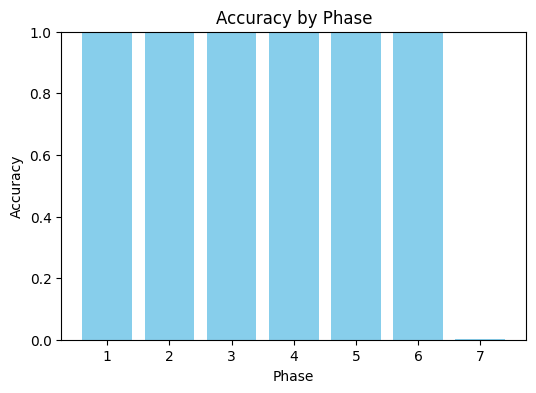

In [25]:
import matplotlib.pyplot as plt

# Accuracy values from each phase
accuracy = [1.0, 1, 1, 1, 1, 1, 0.001]

# Create the figure and bar plot
plt.figure(figsize=(6,4))
plt.bar(range(1, len(accuracy) + 1), accuracy, color='skyblue')

# Configure the axes and labels
plt.xticks(range(1, len(accuracy) + 1))  # x-axis ticks at 1..6
plt.xlabel("Phase")
plt.ylabel("Accuracy")
plt.ylim([0,1])  # optional, to keep y range from 0 to 1
plt.title("Accuracy by Phase")

plt.show()
